# Fitting Data #

In data science, you will often be required to fit data because you want to interpolate between the data points you have, parameterize it, or extract some physical value from the data you have taken with associated uncertainty.

# Interpolation #

If you want to draw a smooth line of best fit between the data taken from the experiment, the simplest method is to use linear interpolation. You can draw a straight line between your data points and then estimate the data between these points. While you can write your own linear interpolation algorithm, a built-in option is available in *scipy*. Another common approach is to use a spline, with a cubic spline being the most commonly used as it provides smoothness and double differentiability. Consider the following example:

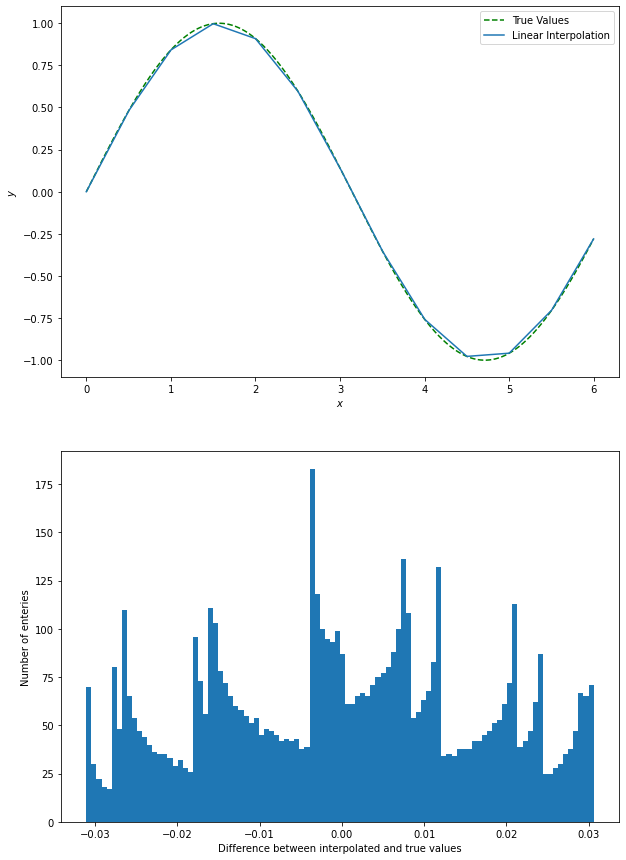

In [32]:
import numpy as np
import scipy as sp
import pylab as pl
import scipy.interpolate as spi
pl.rcParams['figure.figsize'] = [10, 15] 


x=np.arange(0,6.5,0.5) # plus 0.5 to make sure that we get 6
y=np.sin(x)

# now get the finer binned version for comparison
xf=np.arange(0,6,0.001) 
yf=np.sin(xf)

pl.subplot(2,1,1)
pl.plot(xf,yf,"g--",label="True Values")
pl.xlabel("$x$")
pl.ylabel("$y$")

# now the linear 1D interpololation
f=spi.interp1d(x, y)

# f is a function that will return you a value of y for any x
# so now lets compare the difference at a finer scale
pl.plot(xf,f(xf), label="Linear Interpolation")

pl.legend(loc="upper right")



#now lets histogram the differences.
ydiff=yf-f(xf)
pl.subplot(2,1,2)
pl.hist(ydiff,bins=100)
pl.xlabel("Difference between interpolated and true values")
pl.ylabel("Number of enteries")
#pl.xlim([-0.04,0.04])



pl.show()

As shown from the plot above, not only can the differences be quite large, but there is also structure in the differences, which can cause a systematic effect. 

An alternative is to use a spline of some form, with the most common choice being a cubic spline. The example below is identical to the previous one, except that instead of linear interpolation, a cubic spline has been employed.

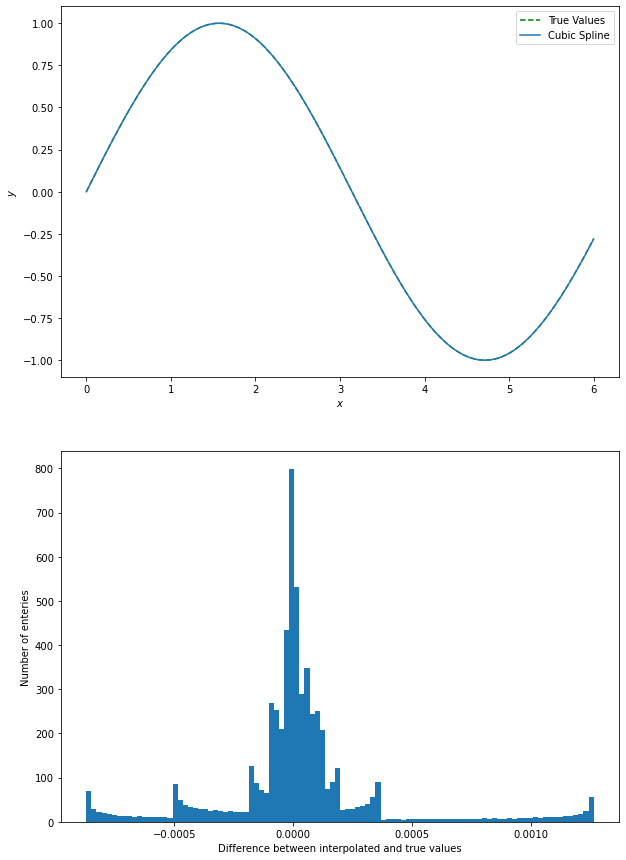

In [33]:
import numpy as np
import scipy as sp
import pylab as pl
import scipy.interpolate as spi
pl.rcParams['figure.figsize'] = [10, 15] 


x=np.arange(0,6.5,0.5) # plus 0.5 to make sure that we get 6
y=np.sin(x)

# now get the finer binned version for comparison
xf=np.arange(0,6,0.001) 
yf=np.sin(xf)

pl.subplot(2,1,1)
pl.plot(xf,yf,"g--",label="True Values")
pl.xlabel("$x$")
pl.ylabel("$y$")

# now the linear interpololation
f=spi.interp1d(x, y, kind='cubic')

# f is a function that will return you a value of y for any x
# so now lets compare the difference at a finer scale
pl.plot(xf,f(xf), label="Cubic Spline")

pl.legend(loc="upper right")



#now lets histogram the differences.


ydiff=yf-f(xf)
pl.subplot(2,1,2)
pl.hist(ydiff,bins=100)
pl.xlabel("Difference between interpolated and true values")
pl.ylabel("Number of enteries")
#pl.xlim([-0.04,0.04])



pl.show()


Using a cubic spline as an approximation provides a much better fit, with significantly smaller differences between the interpolated and true values *(notice the distinct scaling of the x-axis)*. However, even with this improved accuracy, there is still a structure present, resulting in systematic biases (although these biases are small when the differences are small).

Scipy also implements two-dimensional forms of these interpolation algorithms.

It's important to note that while using a cubic spline is generally effective, it is not a foolproof solution. In cases where there aren't enough data points, the cubic spline can occasionally overestimate or underestimate the true curve (as shown in the example below). However, it is generally pretty good.

In [34]:
import numpy as np
pl.rcParams['figure.figsize'] = [10, 10] 
x = np.linspace(0, 10, num=11, endpoint=True)
y = np.cos(-x**2/9.0)
f = spi.interp1d(x, y)
f2 = spi.interp1d(x, y, kind='cubic')

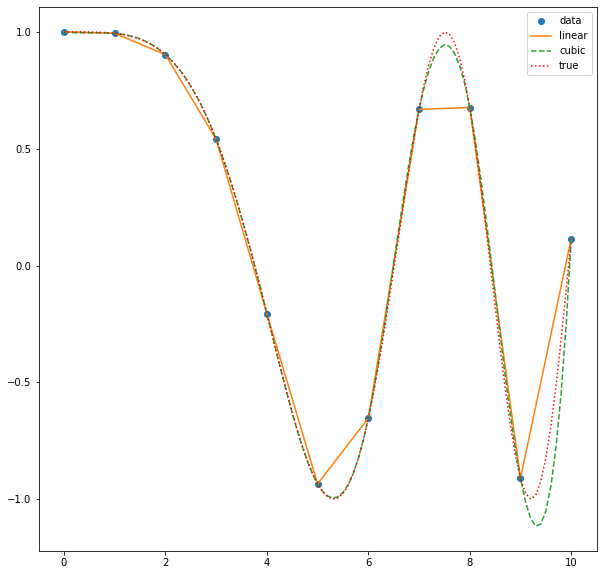

In [35]:
xnew = np.linspace(0, 10, num=101, endpoint=True)
import matplotlib.pyplot as pl
yt=np.cos(-xnew**2/9.0)
pl.plot(x, y, 'o', xnew, f(xnew), '-', xnew, f2(xnew), '--',xnew,yt,'r:')
pl.legend(['data', 'linear', 'cubic','true'], loc='best')
pl.show()

## Exercise 1 ##

The purpose of this exercise is to understand how interpolations work and their limitations.

Select a function that has different scales of structure (such as $y=\cos(x^2)$ with $0 \le x \lt 10$ for example) and investigate how well a cubic spline is able to interpolate with different sampling separations.

# Fitting Data #

One of the most important elements in data analysis is often fitting the data distributions. In performing a fit you minimise how far your fitted solution deviates from the data. When you do perform a fit you are making some assumptions about the data. You may be assuming that they are distributed according to a well defined probability density function (pdf), or that the data points should follow some functional form. In the measurement of all physical quantities the uncertainty on that measurement is paramount to your true understanding of the measurement. 

Scipy does have a series of functions for fitting data in scipy.optimize and these are pretty good. However, we tend to use the more advanced [minuit](https://root.cern.ch/download/minuit.pdf) developed by CERN. This is written in c++ and wrapped in python as [iminuit](https://iminuit.readthedocs.io/en/stable/). 

iminuit has some fantastic [tutorial](https://iminuit.readthedocs.io/en/stable/tutorials.html) on their website and I was tempted to just have you go through those, however they seemed possibly a little too detailed so I have cut and paste some of their content and into the following notes. ***With great thanks to iminuit.***

### The Basics ###

You will learn basic usage of iminuit and how to approach standard fitting problems.

iminuit is a Python frontend to the Minuit library in C++, an integrated software that combines a local minimizer (called Migrad) and two error calculators (called Hesse and the Minos). You provide it an analytical function, which accepts one or several parameters, and an initial guess of the parameter values. It will then find a local minimum of this function starting from the initial guess. In that regard, iminuit minimizer is like other local minimizers, like those in scipy.optimize.

In addition, iminuit has the ability to compute uncertainty estimates for model parameters. iminuit was designed to solve statistics problems, where uncertainty estimates are an essential part of the result. The two ways of computing uncertainty estimates, Hesse and the Minos, have different advantages and disadvantages.

iminuit is the successor of pyminuit. If you used pyminuit before, you will find iminuit very familiar. An important feature of iminuit (and pyminuit) is that it uses introspection to detect the parameter names of your function. This is very convenient, especially when you work interactively in a Jupyter notebook. It also provides special output routines for Jupyter notebooks to pretty print the fit results, as you will see below.

In [36]:
# basic setup of the notebook
from matplotlib import pyplot as plt
import numpy as np

# everything in iminuit is done through the Minuit object, so we import it
from iminuit import Minuit

# we also need a cost function to fit and import the LeastSquares function
from iminuit.cost import LeastSquares

### Quick start ###

In this first section, we look at a simple case where the line should be fitted to a scattered (x,y) data. A line has two parameters (α,β). We go through the full fit, showing all basic steps to get you started quickly. In the following sections we will revisit the steps in more detail.

<ErrorbarContainer object of 3 artists>

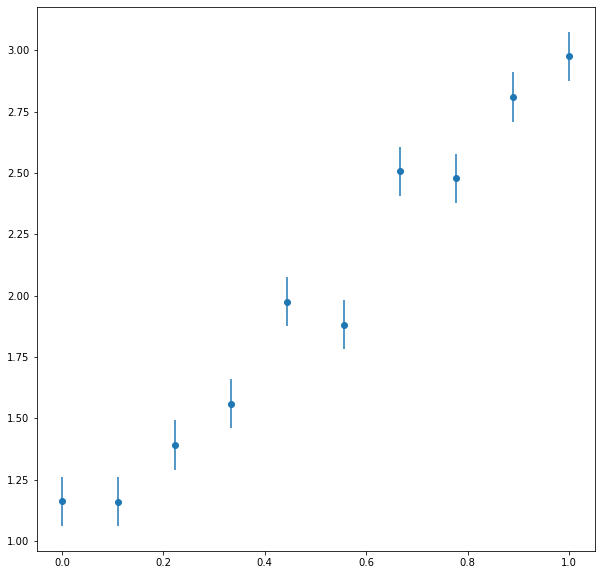

In [37]:
# our line model, unicode parameter names are supported :)
def line(x, α, β):
    return α + x * β


# generate random toy data with random offsets in y
np.random.seed(1)
data_x = np.linspace(0, 1, 10)
data_yerr = 0.1  # could also be an array
data_y = line(data_x, 1, 2) + data_yerr * np.random.randn(len(data_x))

# draw toy data
plt.errorbar(data_x, data_y, data_yerr, fmt="o")

Pro-tip: if you want to use Greek letters, consider installing an additional Greek keyboard layout for easier typing.

To recover the parameters α and β of the line model from this data, we need to a minimize a suitable cost function. The cost function must be twice differentiable and have a minimum at the optimal parameters. We use the method of least-squares here, whose cost function computes the sum of squared residuals between the model and the data. The task of iminuit is to find the minimum of that function. Let’s do it:

┌─────────────────────────────────────────────────────────────────────────┐
│                                Migrad                                   │
├──────────────────────────────────┬──────────────────────────────────────┤
│ FCN = 14.06 (χ²/ndof = 1.8)      │              Nfcn = 46               │
│ EDM = 1.13e-20 (Goal: 0.0002)    │                                      │
├──────────────────────────────────┼──────────────────────────────────────┤
│          Valid Minimum           │   Below EDM threshold (goal x 10)    │
├──────────────────────────────────┼──────────────────────────────────────┤
│      No parameters at limit      │           Below call limit           │
├──────────────────────────────────┼──────────────────────────────────────┤
│             Hesse ok             │         Covariance accurate          │
└──────────────────────────────────┴──────────────────────────────────────┘
┌───┬──────┬───────────┬───────────┬────────────┬────────────┬─────────┬─────────┬──────

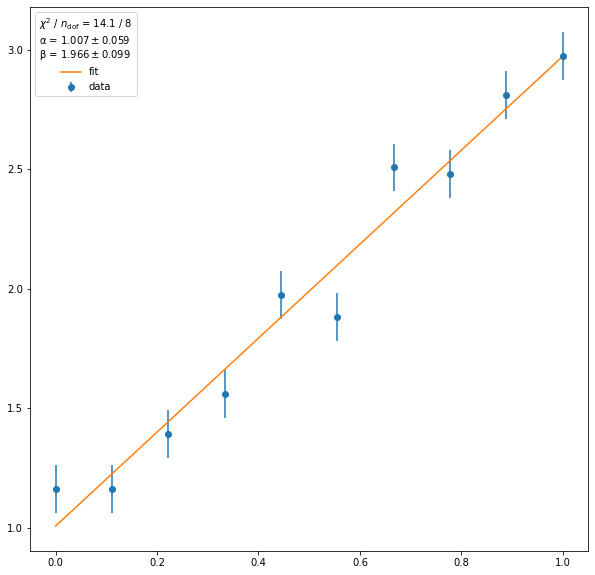

In [38]:
plt.rcParams['figure.figsize'] = [10, 10] 

# iminuit contains a LeastSquares class to conveniently generate a least-squares cost function.
# We will revisit how to write this by hand in a later section.
least_squares = LeastSquares(data_x, data_y, data_yerr, line)

m = Minuit(least_squares, α=0, β=0)  # starting values for α and β

m.migrad()  # finds minimum of least_squares function
m.hesse()   # accurately computes uncertainties



#print the values and errors and then note how to access individual ones.

print(m)

print(m.values)
print(m.errors)


print(m.values[0])
print(m.errors[0])

# draw data and fitted line
plt.errorbar(data_x, data_y, data_yerr, fmt="o", label="data")
plt.plot(data_x, line(data_x, *m.values), label="fit")

# display legend with some fit info
fit_info = [
    f"$\\chi^2$ / $n_\\mathrm{{dof}}$ = {m.fval:.1f} / {len(data_x) - m.nfit}",
]

# try printing out the parameters, values and errors to see the format

for p, v, e in zip(m.parameters, m.values, m.errors):
    fit_info.append(f"{p} = ${v:.3f} \\pm {e:.3f}$")
    

plt.legend(title="\n".join(fit_info))

plt.show()

And that is already it for a basic fit. Easy, right?

In the following, we dive into the details step by step: how the Minuit object is initialized, how to run the algorithms, and how to get the results.

iminuit was designed to make it easy to fit functions like least_squares(...), where the parameters are individual arguments of the function. There is an alternative function signature that Minuit supports, which is more convenient when you work a lot with numpy. Here, the parameters are passed as a numpy array. The two kinds of function definitions have each pros and cons. We will first dive how to work with functions of the first kind and come back to the second kind later.

### Initialize the Minuit object
To minimize a function, one has to create an instance of the Minuit class, pass the function, and a starting value for each parameter. This does not start the minimization yet, this will come later.

The Minuit object uses introspection to get the number and names of the function parameters automatically, so that they can be initialized with keywords.

In [39]:
m = Minuit(least_squares, α=0, β=0)

If we forget a parameter or mistype, Minuit will raise an error.

In [40]:
m=Minuit(least_squares)

RuntimeError: starting value(s) are required for [α β]

In [41]:
m=Minuit(least_squares,a=0,b=0)

RuntimeError: a is not one of the parameters [α β]

### Initial parameter values
Minuit’s main algorithm Migrad is a local minimizer. It searches for a local minimum by a doing a mix of Newton steps and gradient-descents from a starting point. If your function has several minima, the minimum found will depend on the starting point. Even if it has only one minimum, if you start in the proximity of the minimum, iminuit will converge to it faster.

You can set the starting point using the parameter names as keywords, name = value.

In [42]:
Minuit(least_squares, α=5, β=5)  # pass starting values for α and β

,Name,Value,Hesse Error,Minos Error-,Minos Error+,Limit-,Limit+,Fixed
0,α,5.00,0.05,,,,,
1,β,5.00,0.05,,,,,


Alternatively, the starting values can also be passed as positional arguments.

In [43]:
Minuit(least_squares, 5, 5)  # another way of passing starting values for α and β

,Name,Value,Hesse Error,Minos Error-,Minos Error+,Limit-,Limit+,Fixed
0,α,5.00,0.05,,,,,
1,β,5.00,0.05,,,,,


You can also use iminuit with functions that accept numpy arrays. This has pros and cons.

**Pros**

* Easy to change number of fitted parameters
* Sometimes simpler function body that’s easier to read
* Technically this is more efficient, but this is hardly going to be noticable

**Cons**

* iminuit cannot figure out names for each parameter

To demonstrate, use a version of the line model which accepts the parameters as a numpy array.

In [44]:
def line_np(x, par):
    return np.polyval(par, x)  # for len(par) == 2, this is a line

Calling line_np with more or less arguments is easy and will use a polynomial of the corresponding order to predict the behavior of the data.

The builtin cost functions support such a model. For it to be detected properly, you need to pass the starting values in form a single sequence of numbers.



In [45]:
least_squares_np = LeastSquares(data_x, data_y, data_yerr, line_np)

Minuit(least_squares_np, (5, 5))  # pass starting values as a sequence

,Name,Value,Hesse Error,Minos Error-,Minos Error+,Limit-,Limit+,Fixed
0,x0,5.00,0.05,,,,,
1,x1,5.00,0.05,,,,,


Any sequence will work for initialization, you can also pass a list or a numpy array here. iminuit uses the length of the sequence to detect how many parameters the model has. By default, the parameters are named automatically x0 to xN. One can override this with the keyword name, passing a sequence of parameter names.

In [46]:
Minuit(least_squares_np, (5, 5), name=("a", "b"))

,Name,Value,Hesse Error,Minos Error-,Minos Error+,Limit-,Limit+,Fixed
0,a,5.00,0.05,,,,,
1,b,5.00,0.05,,,,,


Since least_squares_np works for parameter arrays of any length, one can easily change the number of fitted parameters.

In [47]:
# fit a forth order polynomial
Minuit(least_squares_np, (5, 5, 5, 5))

,Name,Value,Hesse Error,Minos Error-,Minos Error+,Limit-,Limit+,Fixed
0,x0,5.00,0.05,,,,,
1,x1,5.00,0.05,,,,,
2,x2,5.00,0.05,,,,,
3,x3,5.00,0.05,,,,,


It is often useful to try different orders of a polynomial model. If the order is too small, the polynomial will not follow the data. If it is too large, it will overfit the data and pick up random fluctuations and not the underlying trend. One can figure out the right order by experimenting or using an algorithm like cross-validation.

### Exercise 4

Fit the following data set with different orders of polynomials. As you increase the order of the polynomial how does the goodness of fit change? When does the fit show signs of overfitting? You will need to put commas between the data points, and errors cannot be negative so you need to take the absolute values of these (I generated them according to an algorithm which does allow negative values).

In [48]:
x = [-6, -5, -4, -3, -2, -1, 0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12]

y_measured = [343.39452514, 251.31914561, 186.7806368, 121.30027965, 45.23336652, 23.49470302, 18.46581766, 6.58329486, 1.98522328, -
              6.74799454, -7.55489379, -29.55544088, -31.32898172, -36.27525348, -25.23860169, -1.09156819, 52.32898397, 225.38126087, 460.67437131]

y_err = [141.312, 86.205, 49.632, 26.877, 13.872, 7.197, 4.08, 2.397, 0.672, -
         1.923, -5.568, 9.795, 13.488, -14.883, -11.568, 0.483, 22.08, 60.477, 119.712]


### Inspecting current parameters
You can check the current parameter values and settings with the method Minuit.params at any time. It returns a special list of Param objects which pretty-prints in Jupyter and in the terminal.

In [49]:
m.params

,Name,Value,Hesse Error,Minos Error-,Minos Error+,Limit-,Limit+,Fixed
0,α,0.0,0.1,,,,,
1,β,0.0,0.1,,,,,


This produces a nice table with numbers rounded according to the rules of the Particle Data Group. The table will be updated once you run the actual minimization. To look at the initial conditions later, use Minuit.init_params. We will come back to the meaning of Hesse Error and Minos Error later.

Minuit.params returns a tuple-like container of Param objects, which are data objects with attributes that one can query. Use repr() to get a detailed representation of the data object.



In [52]:
for p in m.params:
    print(repr(p), "\n")

Param(number=0, name='α', value=0.0, error=0.1, merror=None, is_const=False, is_fixed=False, lower_limit=0.0, upper_limit=None) 

Param(number=1, name='β', value=0.0, error=0.1, merror=None, is_const=False, is_fixed=False, lower_limit=0.0, upper_limit=10.0) 



### Parameters with limits
iminuit allows you to set parameter limits. Often a parameter is limited mathematically or physically to a certain range. For example, if your function contains sqrt(x), then x must be non-negative, x ≥ 0. You can set upper-, lower-, or two-sided limits for each parameter individually with the limits property.

* lower limit: use Minuit.limits[<name>] = (<value>, None) or (<value>, float("infinity"))
* upper limit: use Minuit.limits[<name>] = (None, <value>) or (-float("infinity"), <value>)
* two-sided limit: use Minuit.limits[<name>] = (<min_value>, <max_value>)
* remove limits: use Minuit.limits[<name>] = None or (-float("infinity"), float("infinity")

    
 You can also set limits for several parameters at once with a sequence. To impose the limits α≥0 and 0≤β≤10 in our example, we use:

In [53]:
m.limits = [(0, None), (0, 10)]
m.params

,Name,Value,Hesse Error,Minos Error-,Minos Error+,Limit-,Limit+,Fixed
0,α,0.0,0.1,,,0,,
1,β,0.0,0.1,,,0,10,


### Fixing and releasing parameters
In some cases, you may have a parameter that needs to be temporarily set to a fixed value. This can be useful when you have a guess for its value and want to observe how the other parameters adapt when this specific parameter is held constant at that value.

Alternatively, if you have a complex function with numerous parameters that have varying impacts on the function, you can assist the minimizer in finding the minimum faster by initially fixing the less influential parameters to their initial guesses and only fitting the significant parameters. Once the minimum is obtained under these conditions, you can release the fixed parameters and optimize all the parameters together. Minuit retains the previous minimization state and resumes from there. The time required for minimization approximately scales with the square of the number of parameters. By performing iterated minimization over parameter subspaces, this time can be reduced.

To fix an individual parameter, you can utilise the keyword Minuit.fixed[name] = True. In our example, we fix parameter "α" as follows:

In [54]:
m.fixed["α"] = True
m.params

,Name,Value,Hesse Error,Minos Error-,Minos Error+,Limit-,Limit+,Fixed
0,α,0.0,0.1,,,0,,yes
1,β,0.0,0.1,,,0,10,


In [55]:
# migrad will not vary α, only β
m.migrad()

┌─────────────────────────────────────────────────────────────────────────┐
│                                Migrad                                   │
├──────────────────────────────────┬──────────────────────────────────────┤
│ FCN = 307.8 (χ²/ndof = 34.2)     │              Nfcn = 41               │
│ EDM = 2.53e-07 (Goal: 0.0002)    │                                      │
├──────────────────────────────────┼──────────────────────────────────────┤
│          Valid Minimum           │   Below EDM threshold (goal x 10)    │
├──────────────────────────────────┼──────────────────────────────────────┤
│      No parameters at limit      │           Below call limit           │
├──────────────────────────────────┼──────────────────────────────────────┤
│             Hesse ok             │         Covariance accurate          │
└──────────────────────────────────┴──────────────────────────────────────┘
┌───┬──────┬───────────┬───────────┬────────────┬────────────┬─────────┬─────────┬───────┐
│   │ Name │   Value   │ Hesse Err │ Minos Err- │ Minos Err+ │ Limit-  │ Limit+  │ Fixed │
├───┼──────┼───────────┼───────────┼────────────┼────────────┼─────────┼─────────┼───────┤
│ 0 │ α    │    0.0    │    0.1    │            │            │    0    │         │  yes  │
│ 1 │ β    │   3.40    │   0.05    │            │            │    0    │   10    │       │
└───┴──────┴───────────┴───────────┴────────────┴────────────┴─────────┴─────────┴───────┘
┌───┬─────────────────┐
│   │       α       β │
├───┼─────────────────┤
│ α │       0  0.0000 │
│ β │  0.0000 0.00284 │
└───┴─────────────────┘

In [56]:
# now we release α and fix β and minimize again, can also use parameter index
m.fixed[0] = False
m.fixed[1] = True
m.migrad()

┌─────────────────────────────────────────────────────────────────────────┐
│                                Migrad                                   │
├──────────────────────────────────┬──────────────────────────────────────┤
│ FCN = 222.8 (χ²/ndof = 24.8)     │              Nfcn = 77               │
│ EDM = 5.24e-09 (Goal: 0.0002)    │                                      │
├──────────────────────────────────┼──────────────────────────────────────┤
│          Valid Minimum           │   Below EDM threshold (goal x 10)    │
├──────────────────────────────────┼──────────────────────────────────────┤
│      No parameters at limit      │           Below call limit           │
├──────────────────────────────────┼──────────────────────────────────────┤
│             Hesse ok             │         Covariance accurate          │
└──────────────────────────────────┴──────────────────────────────────────┘
┌───┬──────┬───────────┬───────────┬────────────┬────────────┬─────────┬─────────┬───────┐
│   │ Name │   Value   │ Hesse Err │ Minos Err- │ Minos Err+ │ Limit-  │ Limit+  │ Fixed │
├───┼──────┼───────────┼───────────┼────────────┼────────────┼─────────┼─────────┼───────┤
│ 0 │ α    │   0.292   │   0.032   │            │            │    0    │         │       │
│ 1 │ β    │   3.40    │   0.05    │            │            │    0    │   10    │  yes  │
└───┴──────┴───────────┴───────────┴────────────┴────────────┴─────────┴─────────┴───────┘
┌───┬─────────────┐
│   │     α     β │
├───┼─────────────┤
│ α │ 0.001  0e-3 │
│ β │  0e-3     0 │
└───┴─────────────┘

### Varying Starting Points for Minimization ###

It is sometimes useful to change the values of some fixed parameters by hand and fit the others or to restart the fit from another starting point. 

For example, if the cost function has several minima, changing the starting value can be used to find the other minimum.

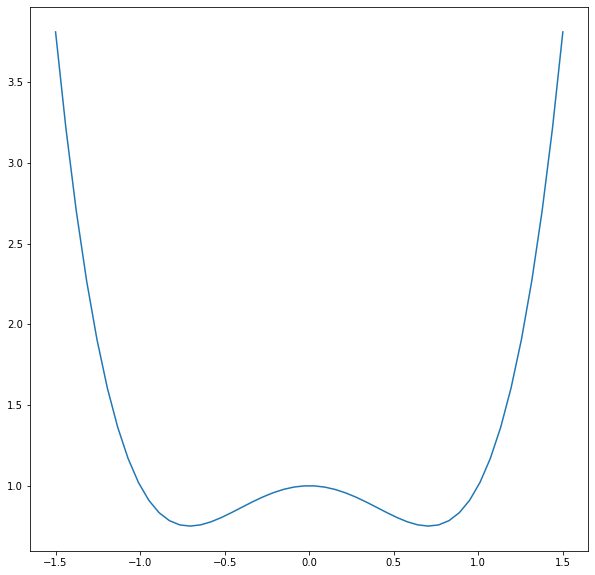

In [57]:
def cost_function_with_two_minima(x):
    return x ** 4 - x ** 2 + 1

# we come back to the meaning of errordef in the next section
cost_function_with_two_minima.errordef = Minuit.LEAST_SQUARES

x = np.linspace(-1.5, 1.5)
plt.plot(x, cost_function_with_two_minima(x));

In [58]:
# starting at -0.1 gives the left minimum
m = Minuit(cost_function_with_two_minima, x=-0.1)
m.migrad()
print("starting value -0.1, minimum at", m.values["x"])

# changing the starting value to 0.1 gives the right minimum
m.values["x"] = 0.1  # m.values[0] = 0.1 also works
m.migrad()
print("starting value +0.1, minimum at", m.values["x"])

starting value -0.1, minimum at -0.7085906080341975
starting value +0.1, minimum at 0.708796091342642


### Advanced: Simplex and Scan minimizers
iminuit also offers two other minimizers which are less powerful than Migrad, but may be useful in special cases.

Simplex
The Nelder-Mead method (aka SIMPLEX) is well described on Wikipedia. It is a gradient-free minimization method that usually converges more slowly, but may be more robust. For some problems it can help to start the minimization with SIMPLEX and then finish with MIGRAD. Since the default stopping criterion for SIMPLEX is much more lax than MIGRAD, either running MIGRAD after SIMPLEX or reducing the tolerance with Minuit.tol is strongly recommended.

In [59]:
Minuit(cost_function_with_two_minima, x=10).simplex()

┌─────────────────────────────────────────────────────────────────────────┐
│                               Simplex                                   │
├──────────────────────────────────┬──────────────────────────────────────┤
│ FCN = 0.7501                     │              Nfcn = 23               │
│ EDM = 0.0176 (Goal: 0.1)         │                                      │
├──────────────────────────────────┼──────────────────────────────────────┤
│          Valid Minimum           │   Below EDM threshold (goal x 10)    │
├──────────────────────────────────┼──────────────────────────────────────┤
│      No parameters at limit      │           Below call limit           │
├──────────────────────────────────┼──────────────────────────────────────┤
│          Hesse not run           │            NO covariance             │
└──────────────────────────────────┴──────────────────────────────────────┘
┌───┬──────┬───────────┬───────────┬────────────┬────────────┬─────────┬─────────┬───────┐
│   │ Name │   Value   │ Hesse Err │ Minos Err- │ Minos Err+ │ Limit-  │ Limit+  │ Fixed │
├───┼──────┼───────────┼───────────┼────────────┼────────────┼─────────┼─────────┼───────┤
│ 0 │ x    │    0.7    │    0.8    │            │            │         │         │       │
└───┴──────┴───────────┴───────────┴────────────┴────────────┴─────────┴─────────┴───────┘

Let’s run MIGRAD to finish the minimization.

In [60]:
Minuit(cost_function_with_two_minima, x=10).simplex().migrad()

┌─────────────────────────────────────────────────────────────────────────┐
│                                Migrad                                   │
├──────────────────────────────────┬──────────────────────────────────────┤
│ FCN = 0.75                       │              Nfcn = 36               │
│ EDM = 1.12e-08 (Goal: 0.0002)    │                                      │
├──────────────────────────────────┼──────────────────────────────────────┤
│          Valid Minimum           │   Below EDM threshold (goal x 10)    │
├──────────────────────────────────┼──────────────────────────────────────┤
│      No parameters at limit      │           Below call limit           │
├──────────────────────────────────┼──────────────────────────────────────┤
│             Hesse ok             │         Covariance accurate          │
└──────────────────────────────────┴──────────────────────────────────────┘
┌───┬──────┬───────────┬───────────┬────────────┬────────────┬─────────┬─────────┬───────┐
│   │ Name │   Value   │ Hesse Err │ Minos Err- │ Minos Err+ │ Limit-  │ Limit+  │ Fixed │
├───┼──────┼───────────┼───────────┼────────────┼────────────┼─────────┼─────────┼───────┤
│ 0 │ x    │    0.7    │    0.7    │            │            │         │         │       │
└───┴──────┴───────────┴───────────┴────────────┴────────────┴─────────┴─────────┴───────┘
┌───┬─────┐
│   │   x │
├───┼─────┤
│ x │ 0.5 │
└───┴─────┘

This combination uses slightly fewer function evaluations and produces a more accurate result than just running MIGRAD alone in this case (for another problem this may not be true).

### Scan

Scan is a last resort. It creates a N-dimensional grid scan over the parameter space. The number of function evaluations scale like nk, where k is the number of parameters and n the number of steps along one dimension. Using 'scan' for high-dimensional problems is unfeasible, but it can be useful in low-dimensional problems and when all but a few parameters are fixed. The scan needs bounds, which are best set with Minuit.limits. The number of scan points is set with the ncall keyword.

In [61]:
m = Minuit(cost_function_with_two_minima, x=10)
m.limits = (-10, 10)
m.scan(ncall=50)

┌─────────────────────────────────────────────────────────────────────────┐
│                                 Scan                                    │
├──────────────────────────────────┬──────────────────────────────────────┤
│ FCN = 0.7657                     │              Nfcn = 55               │
│ EDM = 0.0188 (Goal: 0.1)         │                                      │
├──────────────────────────────────┼──────────────────────────────────────┤
│          Valid Minimum           │   Below EDM threshold (goal x 10)    │
├──────────────────────────────────┼──────────────────────────────────────┤
│      No parameters at limit      │           Below call limit           │
├──────────────────────────────────┼──────────────────────────────────────┤
│          Hesse not run           │            NO covariance             │
└──────────────────────────────────┴──────────────────────────────────────┘
┌───┬──────┬───────────┬───────────┬────────────┬────────────┬─────────┬─────────┬───────┐
│   │ Name │   Value   │ Hesse Err │ Minos Err- │ Minos Err+ │ Limit-  │ Limit+  │ Fixed │
├───┼──────┼───────────┼───────────┼────────────┼────────────┼─────────┼─────────┼───────┤
│ 0 │ x    │   -0.6    │    0.9    │            │            │   -10   │   10    │       │
└───┴──────┴───────────┴───────────┴────────────┴────────────┴─────────┴─────────┴───────┘

The scan brought us in close proximity of the minimum.

In this case, the minimum is considered valid, because the EDM value is smaller than the EDM goal, but the scan may also end up in an invalid minimum, which is also ok. The scan minimizes the cost function using a finite number of steps, regardless of the EDM value (which is only computed after the scan for the minimum).

One should always run MIGRAD or SIMPLEX after a SCAN. This is often a good way to find the minimum that you are looking for.

### Advanced: Errordef

If you do not use one of the cost functions from the iminuit.cost module, you need to pass an additional parameter to Minuit. Let’s make a custom least-squares function and try to run Migrad on it.



In [62]:
# a simple least-squares cost function looks like this...
def custom_least_squares(a, b):
    ym = line(data_x, a, b)
    z = (data_y - ym) / data_yerr
    return np.sum(z ** 2)


Minuit(custom_least_squares, a=5, b=5).migrad()

┌─────────────────────────────────────────────────────────────────────────┐
│                                Migrad                                   │
├──────────────────────────────────┬──────────────────────────────────────┤
│ FCN = 14.06                      │              Nfcn = 30               │
│ EDM = 3.33e-22 (Goal: 0.0002)    │                                      │
├──────────────────────────────────┼──────────────────────────────────────┤
│          Valid Minimum           │   Below EDM threshold (goal x 10)    │
├──────────────────────────────────┼──────────────────────────────────────┤
│      No parameters at limit      │           Below call limit           │
├──────────────────────────────────┼──────────────────────────────────────┤
│             Hesse ok             │         Covariance accurate          │
└──────────────────────────────────┴──────────────────────────────────────┘
┌───┬──────┬───────────┬───────────┬────────────┬────────────┬─────────┬─────────┬───────┐
│   │ Name │   Value   │ Hesse Err │ Minos Err- │ Minos Err+ │ Limit-  │ Limit+  │ Fixed │
├───┼──────┼───────────┼───────────┼────────────┼────────────┼─────────┼─────────┼───────┤
│ 0 │ a    │   1.01    │   0.06    │            │            │         │         │       │
│ 1 │ b    │   1.97    │   0.10    │            │            │         │         │       │
└───┴──────┴───────────┴───────────┴────────────┴────────────┴─────────┴─────────┴───────┘
┌───┬─────────────────┐
│   │       a       b │
├───┼─────────────────┤
│ a │ 0.00345 -0.0049 │
│ b │ -0.0049 0.00982 │
└───┴─────────────────┘

Minuit now warns about using its default value for the errordef parameter, which may not be appropriate. Setting this is not needed for the cost functions in iminuit.cost, but it is needed for custom cost functions.

The errordef parameter is used to compute the correct uncertainties. If you don’t care about uncertainty estimates (but why are you using Minuit then?), you can ignore the warning. In statistical problems, there are two kinds of cost functions to minimize, the negative log-likelihood and the least-squares function. Each has a corresponding value for errordef: - 0.5 or the constant Minuit.LIKELIHOOD for negative log-likelihood functions - 1 or the constant Minuit.LEAST_SQUARES for least-squares functions

The origin of these numbers is not too complicated, but cannot be explained briefly. If you are curious, have a look into the tutorial “Error computation with HESSE and MINOS”, which explains in depth how uncertainties are computed and where this value comes from.

For our custom cost function, we need to set m.errordef=1 or equivalent and more readable m.errordef=Minuit.LEAST_SQUARES, because it is of the least-squares type. If we do that, the warning disappears.



In [63]:
m = Minuit(custom_least_squares, a=5, b=5)
m.errordef = Minuit.LEAST_SQUARES
m.migrad()  # no warning

┌─────────────────────────────────────────────────────────────────────────┐
│                                Migrad                                   │
├──────────────────────────────────┬──────────────────────────────────────┤
│ FCN = 14.06                      │              Nfcn = 30               │
│ EDM = 3.33e-22 (Goal: 0.0002)    │                                      │
├──────────────────────────────────┼──────────────────────────────────────┤
│          Valid Minimum           │   Below EDM threshold (goal x 10)    │
├──────────────────────────────────┼──────────────────────────────────────┤
│      No parameters at limit      │           Below call limit           │
├──────────────────────────────────┼──────────────────────────────────────┤
│             Hesse ok             │         Covariance accurate          │
└──────────────────────────────────┴──────────────────────────────────────┘
┌───┬──────┬───────────┬───────────┬────────────┬────────────┬─────────┬─────────┬───────┐
│   │ Name │   Value   │ Hesse Err │ Minos Err- │ Minos Err+ │ Limit-  │ Limit+  │ Fixed │
├───┼──────┼───────────┼───────────┼────────────┼────────────┼─────────┼─────────┼───────┤
│ 0 │ a    │   1.01    │   0.06    │            │            │         │         │       │
│ 1 │ b    │   1.97    │   0.10    │            │            │         │         │       │
└───┴──────┴───────────┴───────────┴────────────┴────────────┴─────────┴─────────┴───────┘
┌───┬─────────────────┐
│   │       a       b │
├───┼─────────────────┤
│ a │ 0.00345 -0.0049 │
│ b │ -0.0049 0.00982 │
└───┴─────────────────┘

### Investigating the fit status
Calling Minuit.migrad() runs the actual minimization with the Migrad algorithm. Migrad essentially tries a Newton-step and if that does not produce a smaller function value, it tries a line search along the direction of the gradient. So far so ordinary. The clever bits in Migrad are how various pathological cases are handled.

Let’s look again at the output of Minuit.migrad().



In [64]:
m = Minuit(least_squares, α=5, β=5)
m.migrad()

┌─────────────────────────────────────────────────────────────────────────┐
│                                Migrad                                   │
├──────────────────────────────────┬──────────────────────────────────────┤
│ FCN = 14.06 (χ²/ndof = 1.8)      │              Nfcn = 30               │
│ EDM = 1.58e-21 (Goal: 0.0002)    │                                      │
├──────────────────────────────────┼──────────────────────────────────────┤
│          Valid Minimum           │   Below EDM threshold (goal x 10)    │
├──────────────────────────────────┼──────────────────────────────────────┤
│      No parameters at limit      │           Below call limit           │
├──────────────────────────────────┼──────────────────────────────────────┤
│             Hesse ok             │         Covariance accurate          │
└──────────────────────────────────┴──────────────────────────────────────┘
┌───┬──────┬───────────┬───────────┬────────────┬────────────┬─────────┬─────────┬───────┐
│   │ Name │   Value   │ Hesse Err │ Minos Err- │ Minos Err+ │ Limit-  │ Limit+  │ Fixed │
├───┼──────┼───────────┼───────────┼────────────┼────────────┼─────────┼─────────┼───────┤
│ 0 │ α    │   1.01    │   0.06    │            │            │         │         │       │
│ 1 │ β    │   1.97    │   0.10    │            │            │         │         │       │
└───┴──────┴───────────┴───────────┴────────────┴────────────┴─────────┴─────────┴───────┘
┌───┬─────────────────┐
│   │       α       β │
├───┼─────────────────┤
│ α │ 0.00345 -0.0049 │
│ β │ -0.0049 0.00982 │
└───┴─────────────────┘

The Minuit.migrad method returns the Minuit instance so that one can chain method calls, the instance also pretty prints the latest state of the minimization.

The first block in this output is showing information about the function minimum. This is good for a quick check:

All blocks should be green.
* Purple means something bad.
* Yellow may be bad or not. Be careful.
* Let’s see how it looks when the function is bad.



In [65]:
m_bad = Minuit(lambda x: 0, x=1)  # a constant function has no minimum
m_bad.errordef = 1  # avoid the errordef warning
m_bad.migrad()

┌─────────────────────────────────────────────────────────────────────────┐
│                                Migrad                                   │
├──────────────────────────────────┬──────────────────────────────────────┤
│ FCN = 0                          │              Nfcn = 80               │
│ EDM = 0 (Goal: 0.0002)           │                                      │
├──────────────────────────────────┼──────────────────────────────────────┤
│         INVALID Minimum          │   Below EDM threshold (goal x 10)    │
├──────────────────────────────────┼──────────────────────────────────────┤
│      No parameters at limit      │           Below call limit           │
├──────────────────────────────────┼──────────────────────────────────────┤
│           Hesse FAILED           │       Covariance NOT pos. def.       │
└──────────────────────────────────┴──────────────────────────────────────┘
┌───┬──────┬───────────┬───────────┬────────────┬────────────┬─────────┬─────────┬───────┐
│   │ Name │   Value   │ Hesse Err │ Minos Err- │ Minos Err+ │ Limit-  │ Limit+  │ Fixed │
├───┼──────┼───────────┼───────────┼────────────┼────────────┼─────────┼─────────┼───────┤
│ 0 │ x    │     1     │     0     │            │            │         │         │       │
└───┴──────┴───────────┴───────────┴────────────┴────────────┴─────────┴─────────┴───────┘

Coming back to our previous good example, the info about the function minimum can be directly accessed with Minuit.fmin:



In [66]:
m.fmin

┌─────────────────────────────────────────────────────────────────────────┐
│                                Migrad                                   │
├──────────────────────────────────┬──────────────────────────────────────┤
│ FCN = 14.06 (χ²/ndof = 1.8)      │              Nfcn = 30               │
│ EDM = 1.58e-21 (Goal: 0.0002)    │                                      │
├──────────────────────────────────┼──────────────────────────────────────┤
│          Valid Minimum           │   Below EDM threshold (goal x 10)    │
├──────────────────────────────────┼──────────────────────────────────────┤
│      No parameters at limit      │           Below call limit           │
├──────────────────────────────────┼──────────────────────────────────────┤
│             Hesse ok             │         Covariance accurate          │
└──────────────────────────────────┴──────────────────────────────────────┘

In [67]:
# print(repr(...)) to see a detailed representation of the data object
print(repr(m.fmin))

<FMin algorithm='Migrad' edm=1.5774541063068123e-21 edm_goal=0.0002 errordef=1.0 fval=14.064905067721467 has_accurate_covar=True has_covariance=True has_made_posdef_covar=False has_parameters_at_limit=False has_posdef_covar=True has_reached_call_limit=False has_valid_parameters=True hesse_failed=False is_above_max_edm=False is_valid=True nfcn=30 ngrad=0 reduced_chi2=1.7581131334651834 time=0.014037625000128173>


The most important one here is is_valid. If this is false, the fit does not converge and the result is useless. Since this is so often queried, a shortcut is provided with Minuit.valid.

If the fit fails, there is usually a numerical or logical issue.

The fit function is not analytical everywhere in the parameter space or does not have a local minimum (the minimum may be at infinity, the extremum may be a saddle point or maximum). Indicators for this are is_above_max_edm=True, hesse_failed=True, has_posdef_covar=False, or has_made_posdef_covar=True. A non-analytical function is one with a discrete step, for example.
* Migrad reached the call limit before the convergence so that has_reached_call_limit=True. The used number of function calls is nfcn, and the call limit can be changed with the keyword argument ncall in the method Minuit.migrad. Note that nfcn can be slightly larger than ncall, because Migrad internally only checks this condition after a full iteration, in which several function calls can happen.
* Migrad detects convergence by a small edm value, the estimated distance to minimum. This is the difference between the current minimum value of the minimized function and the prediction based on the current local quadratic approximation of the function (something that Migrad computes as part of its algorithm). If the fit does not converge, is_above_max_edm is true.

If you are interested in parameter uncertainties, you should make sure that:

* has_covariance, has_accurate_covar, and has_posdef_covar are true.
* has_made_posdef_covar and hesse_failed are false.
The second object of interest after the fit is the parameter list, which can be directly accessed with Minuit.params.

In [68]:
m.params

,Name,Value,Hesse Error,Minos Error-,Minos Error+,Limit-,Limit+,Fixed
0,α,1.01,0.06,,,,,
1,β,1.97,0.10,,,,,


m.params is a tuple-like container of Param data objects which contain information about the fitted parameters. Important fields are: 
- number: parameter index. 
- name: parameter name. 
- value: value of the parameter at the minimum. 
- error: uncertainty estimate for the parameter value.

The accuracy of the uncertainty estimate depends on two factors: the correct mathematical modeling of the fitting problem and the appropriate usage of the errordef value in Minuit. But what exactly do we mean by "correct mathematical modeling"? To understand this, let's examine the function simple_least_squares(a, b). Notice that each squared residual is divided by the expected variance of the residual. This division is crucial for obtaining accurate uncertainty estimates for the parameters.

In some cases, the expected variance of the residual may not be well-known. When the function to minimize is a least-squares function, there is a simple test to assess the adequacy of the residual variances. One can evaluate the function value at the minimum, denoted by fmin.fval, and divide it by the difference between the number of residuals and the number of fitted parameters. This difference can be conveniently obtained using the nfit attribute. This metric is referred to as the reduced chi2.

In [69]:
m.fval / (len(data_y) - m.nfit)  # reduced chi2

1.7581131334651834

This value should be around 1. The more data points one has, the closer. If the value is much larger than 1, then the data variance is underestimated or the model does not describe the data. If the value is much smaller than 1, then the data variance is overestimated (perhaps because of positive correlations between the fluctuations of the data values).

The last block shows the covariance matrix, this is useful to check for large correlations which are usually a sign of trouble.



### Parameter Uncertainties, Covariances, and Confidence Intervals
You saw how to get the uncertainty of each individual parameter and how to access the full covariance matrix of all parameters together, which includes the correlations. Correlations are essential additional information if you want to work with parameter uncertainties seriously.

Minuit offers two ways to compute the parameter uncertainties, Hesse and Minos. Both have pros and cons.

#### Hesse for Covariance and Correlation Matrices
The Hesse algorithm numerically computes the matrix of second derivatives at the function minimum (called the Hesse matrix) and inverts it. The Hesse matrix is symmetric by construction. In the limit of infinite data samples to fit, the result of this computation converges to the true covariance matrix of the parameters. It often is already a good approximation even for finite statistic. These errors obtained from this method are sometimes called parabolic errors, because the Hesse matrix method is exact if the function is a hyperparabola (third and higher-order derivatives are all zero).

**Pros**

* (Comparably) fast computation.
* Provides covariance matrix for error propagation.

**Cons**

* May not have good coverage probability when sample size is small

The Migrad algorithm computes an approximation of the Hesse matrix automatically during minimization. When the default strategy is used, Minuit does a check whether this approximation is sufficiently accurate and if not, it computes the Hesse matrix automatically.

All this happens inside C++ Minuit and is a bit intransparent, so to be on the safe side, we recommend to call Minuit.hesse explicitly after the minimization, if exact errors are important.

In [70]:
# let's mess up the current errors a bit so that hesse has something to do
m.errors = (0.16, 0.2)
m.params

,Name,Value,Hesse Error,Minos Error-,Minos Error+,Limit-,Limit+,Fixed
0,α,1.01,0.16,,,,,
1,β,1.97,0.20,,,,,


In [71]:
m.hesse().params # note the change in "Hesse Error"

,Name,Value,Hesse Error,Minos Error-,Minos Error+,Limit-,Limit+,Fixed
0,α,1.01,0.06,,,,,
1,β,1.97,0.10,,,,,


#### Covariance and correlation Matrix
To see the covariance matrix of the parameters, you do:


In [72]:
m.covariance

,α,β
α,0.00345,-0.0049 (-0.843)
β,-0.0049 (-0.843),0.00982


In [73]:
print(repr(m.covariance))

[[ 0.00345455 -0.00490909]
 [-0.00490909  0.00981818]]


To get the correlation matrix

In [74]:
m.covariance.correlation()

,α,β
α,1,-0.8
β,-0.8,1


Nonzero correlation is not necessarily a bad thing, but if you have freedom in redefining the parameters of the fit function, it is good to choose parameters which are not strongly correlated.

Minuit cannot accurately minimise the function if two parameters are (almost) perfectly (anti-)correlated. It also means that one of two parameters is superfluous - it doesn’t add new information. You should rethink the fit function in this case and try to remove one of the parameters from the fit.

Both matrices are subclasses of numpy.ndarray, so you can use them everywhere you would use a numpy array. In addition, these matrices support value access via parameter names:

In [75]:
m.covariance["α", "β"]

-0.004909092060230799

### Minos for non-parabolic minima
Minuit has another algorithm to compute uncertainties: Minos. It implements the so-called profile likelihood method, where the neighborhood around the function minimum is scanned until the contour is found where the function increase by the value of errordef. The contour defines a confidence region that covers the true parameter point with a certain probability. The probability is exactly known in the limit of infinitely large data samples, but approximate for the finite case. Please consult a textbook about statistics about the mathematical details or look at the tutorial “Error computation with HESSE and MINOS”.

**Pros**

* Produces pretty confidence regions in 2D (or higher) for scientific plots

**Cons**

* Computationally expensive
* Asymmetric errors are difficult to error-propagate

Minos is not automatically called during minimization, it needs to be called explicitly afterwards, like so:

In [76]:
m.minos()

┌─────────────────────────────────────────────────────────────────────────┐
│                               External                                  │
├──────────────────────────────────┬──────────────────────────────────────┤
│ FCN = 14.06 (χ²/ndof = 1.8)      │              Nfcn = 77               │
│ EDM = 2.75e-20 (Goal: 0.0002)    │                                      │
├──────────────────────────────────┼──────────────────────────────────────┤
│          Valid Minimum           │   Below EDM threshold (goal x 10)    │
├──────────────────────────────────┼──────────────────────────────────────┤
│      No parameters at limit      │           Below call limit           │
├──────────────────────────────────┼──────────────────────────────────────┤
│             Hesse ok             │         Covariance accurate          │
└──────────────────────────────────┴──────────────────────────────────────┘
┌───┬──────┬───────────┬───────────┬────────────┬────────────┬─────────┬─────────┬───────┐
│   │ Name │   Value   │ Hesse Err │ Minos Err- │ Minos Err+ │ Limit-  │ Limit+  │ Fixed │
├───┼──────┼───────────┼───────────┼────────────┼────────────┼─────────┼─────────┼───────┤
│ 0 │ α    │   1.01    │   0.06    │   -0.06    │    0.06    │         │         │       │
│ 1 │ β    │   1.97    │   0.10    │   -0.10    │    0.10    │         │         │       │
└───┴──────┴───────────┴───────────┴────────────┴────────────┴─────────┴─────────┴───────┘
┌──────────┬───────────────────────┬───────────────────────┐
│          │           α           │           β           │
├──────────┼───────────┬───────────┼───────────┬───────────┤
│  Error   │   -0.06   │   0.06    │   -0.1    │    0.1    │
│  Valid   │   True    │   True    │   True    │   True    │
│ At Limit │   False   │   False   │   False   │   False   │
│ Max FCN  │   False   │   False   │   False   │   False   │
│ New Min  │   False   │   False   │   False   │   False   │
└──────────┴───────────┴───────────┴───────────┴───────────┘
┌───┬─────────────────┐
│   │       α       β │
├───┼─────────────────┤
│ α │ 0.00345 -0.0049 │
│ β │ -0.0049 0.00982 │
└───┴─────────────────┘

By now, you have likely become accustomed to seeing green colors, which indicate that Minos has run successfully. However, it is crucial to exercise caution if these colors turn red instead, as it signifies a failure of Minos. The fields in the new Minos table carry the following meanings:

* Valid: Indicates whether Minos considers the scan result valid. 
* At Limit: Becomes true if Minos encounters a parameter limit before completing the contour, which is undesirable.
* Max FCN: Becomes true if Minos reaches the maximum number of allowed calls before completing the contour, also an undesirable outcome.
* New Min: Becomes true if Minos discovers a deeper local minimum in the vicinity of the current one. While not necessarily problematic, it should ideally be avoided.

The errors computed by Minos are now also shown in the parameter list.

In [77]:
m.params

,Name,Value,Hesse Error,Minos Error-,Minos Error+,Limit-,Limit+,Fixed
0,α,1.01,0.06,-0.06,0.06,,,
1,β,1.97,0.10,-0.10,0.10,,,


#### Coverage Probability of Intervals Constructed with Hesse and Minos Algorithms
In applications, it is important to construct confidence regions with a well-known coverage probability. As previously mentioned, the coverage probability of the intervals constructed from the uncertainties reported by Hesse and Minos are not necessarily the standard 68 %.

Whether Hesse or Minos produce an interval with a coverage probability closer to the desired 68 % in finite samples depends on the case. There are theoretical results which suggest that Hesse may be slightly better, but we also found special cases where Minos intervals performed better.

Some sources claim that Minos gives better coverage when the cost function is not parabolic around the minimum; that is not generally true, in fact Hesse intervals may have better coverage.

As a rule-of-thumb, use Hesse as the default and try both algorithms if accurate coverage probability matters.

### Quick access to fit results
You get the main fit results with properties and methods from the Minuit object. We used several of them already. Here is a summary:

In [78]:
print(m.values)  # array-like view of the parameter values

# access values by name or index
print("by name ", m.values["α"])
print("by index", m.values[0])

# iterate over values
for key, value in zip(m.parameters, m.values):
    print(f"{key} = {value}")
    
# slicing works
print(m.values[:1])

print(m.errors)  # array-like view of symmetric uncertainties

<ValueView α=1.007267694540621 β=1.9660364327564714>
by name  1.007267694540621
by index 1.007267694540621
α = 1.007267694540621
β = 1.9660364327564714
[1.007267694540621]
<ErrorView α=0.058775386128484715 β=0.099086750179578>


Minuit.errors supports the same access as Minuit.values.

In [79]:
print(m.params) # parameter info (using str(m.params))

print(repr(m.params)) # parameter info (using repr(m.params))

# asymmetric uncertainties (using str(m.merrors))
print(m.merrors)

print(m.covariance)  # covariance matrix computed by Hesse (using str(m.covariance))
print(repr(m.covariance))  # covariance matrix computed by Hesse (using repr(m.covariance))

┌───┬──────┬───────────┬───────────┬────────────┬────────────┬─────────┬─────────┬───────┐
│   │ Name │   Value   │ Hesse Err │ Minos Err- │ Minos Err+ │ Limit-  │ Limit+  │ Fixed │
├───┼──────┼───────────┼───────────┼────────────┼────────────┼─────────┼─────────┼───────┤
│ 0 │ α    │   1.01    │   0.06    │   -0.06    │    0.06    │         │         │       │
│ 1 │ β    │   1.97    │   0.10    │   -0.10    │    0.10    │         │         │       │
└───┴──────┴───────────┴───────────┴────────────┴────────────┴─────────┴─────────┴───────┘
(Param(number=0, name='α', value=1.007267694540621, error=0.058775386128484715, merror=(-0.058775381364227115, 0.058775381364824526), is_const=False, is_fixed=False, lower_limit=None, upper_limit=None), Param(number=1, name='β', value=1.9660364327564714, error=0.099086750179578, merror=(-0.09908673886090376, 0.09908673886184209), is_const=False, is_fixed=False, lower_limit=None, upper_limit=None))
┌──────────┬───────────────────────┬─────────────────

As already mentioned, you can play around with iminuit by assigning new values to m.values and m.errors and then run m.migrad() again. The values will be used as a starting point.

### Plotting

iminuit comes with buildin methods to draw the confidence regions around the minimum, like so:

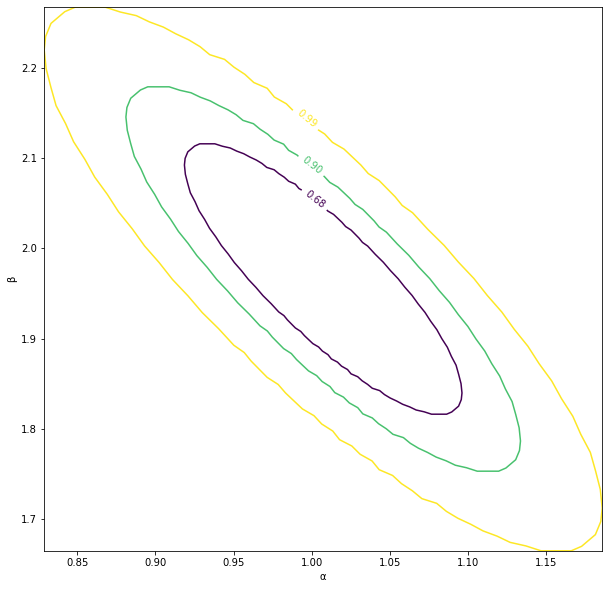

In [80]:
# find the minimum again after messing around with the parameters
m.migrad()

# draw three contours with 68%, 90%, 99% confidence level
m.draw_mncontour("α", "β", cl=(0.68, 0.9, 0.99))

Asymptotically (in large samples), the cl is equal to the probability that the region contains the true value. In finite samples, this is usually only approximately equivilent.



In [81]:
# get individual contours to plot them yourself
ctr_xy = m.mncontour("α", "β", cl=0.68, size=10)
print(ctr_xy)

[[0.91854084 2.09212197]
 [0.93860627 2.01263553]
 [0.97400646 1.9386927 ]
 [1.019001   1.86959111]
 [1.08205798 1.81645587]
 [1.09599455 1.8399509 ]
 [1.07592912 1.91943733]
 [1.04052893 1.99338016]
 [0.99553439 2.06248175]
 [0.93247741 2.115617  ]
 [0.91854084 2.09212197]]


If you need to inspect the cost function around the minimum because MINUIT warns you about some issues, you can quickly scan it with a call to Minuit.draw_profile.

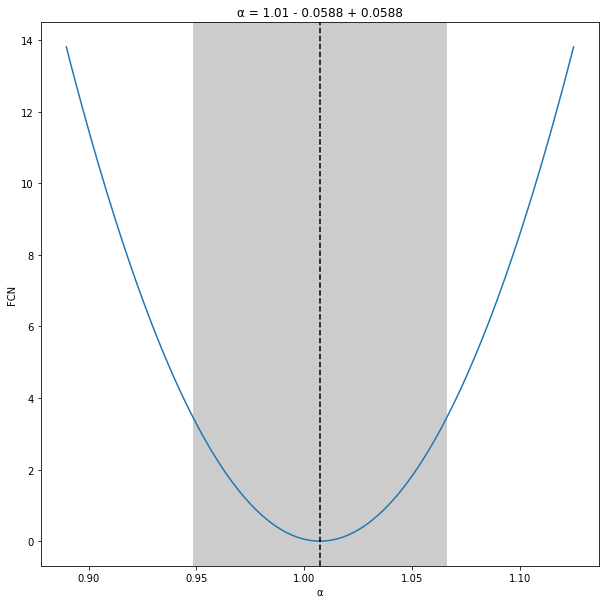

In [82]:
m.draw_profile("α");

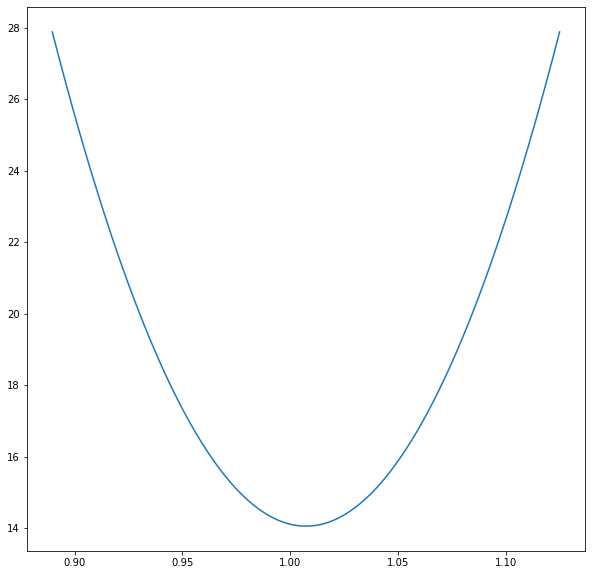

In [83]:
# or use this to plot the result of the scan yourself
a, fa = m.profile("α")
plt.plot(a, fa)

Alternatively, you can use mnprofile to do a full profile likelihood scan. This mimics what MINOS does to compute confidence intervals. If you have trouble with MINOS, running this may help to inspect the issue.

This is computationally expensive, since the scan runs MIGRAD for each point on the profile.



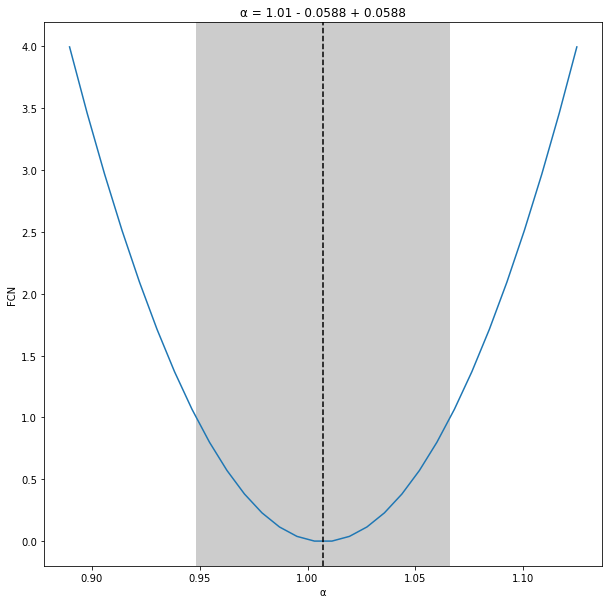

In [84]:
m.draw_mnprofile("α");

Finally, you can also look at the 2D contours of the cost function around the minimum. Note that these are just contours of the fit function, not confidence regions. The latter you can only get from mncontour.

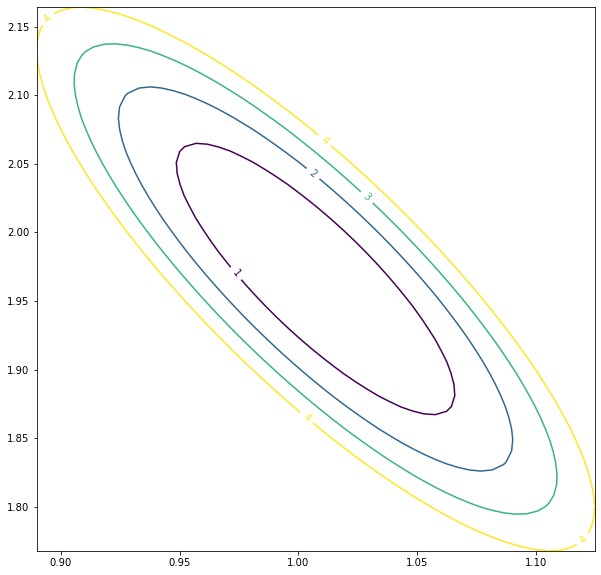

In [85]:
x, y, z = m.contour("α", "β", subtract_min=True)
#print(len(x))
cs = plt.contour(x, y, z, (1, 2, 3, 4))  # these are not sigmas, just the contour values
plt.clabel(cs);

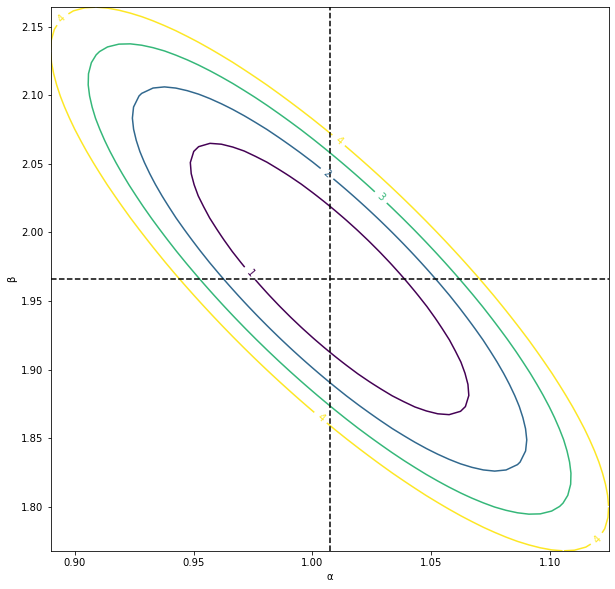

In [86]:
# or use this function for a quick look
m.draw_contour("α", "β");

### Cost functions
We give an in-depth guide on how to use the builtin cost functions.

The iminuit package comes with a couple of common cost functions that you can import from iminuit.cost for convenience. Of course, you can write your own cost functions to use with iminuit, but most of the cost function is always the same. What really varies is the statistical model which predicts the probability density as a function of the parameter values. This you still have to provide yourself and the iminuit package will not include machinery to build statistical models (that is out of scope).

Using the builtin cost functions is not only convenient, they also have some extra features.

* Support of fitted weighted histograms.
* Technical tricks improve numerical stability.
* Optional numba acceleration (if numba is installed).
* Cost functions can be added to fit data sets with shared parameters.
* Temporarily mask data.


We demonstrate each cost function on an standard example from high-energy physics, the fit of a peak over some smooth background (here taken to be constant).



In [87]:
from iminuit import cost, Minuit
from scipy.stats import norm, uniform
import numpy as np
from matplotlib import pyplot as plt

We generate our data. We sample from a Gaussian peak around 0 with width 0.1 and from uniform background from -1 to 1. We then bin the original data. One can fit the original or the binned data. The latter is often much faster and if the binning is fine enough, there is no loss in precision as we will see.

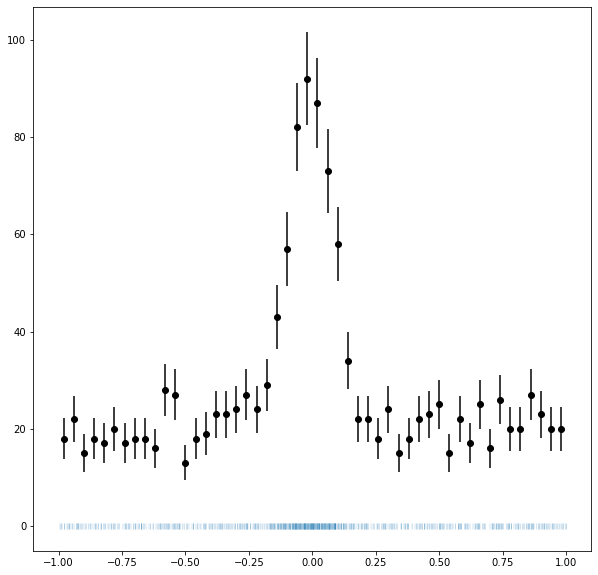

In [88]:
xrange = -1, 1

rng = np.random.default_rng(1)

xdata = rng.normal(0, 0.1, size=400)
xdata = np.append(xdata, rng.uniform(*xrange, size=1000))

n, xe = np.histogram(xdata, bins=50, range=xrange)  
cx = 0.5 * (xe[1:] + xe[:-1])
dx = np.diff(xe)

plt.errorbar(cx, n, n ** 0.5, fmt="ok")
plt.plot(xdata, np.zeros_like(xdata), "|", alpha=0.1);

### Maximum-likelihood fits

You will learn about Maximum-liklehoods in a few weeks in the

Maximum-likelihood fits are the state-of-the-art when it comes to fitting models to data. The can be applied to unbinned and binned data (histograms).

* Unbinned fits are the easiest to use, because they can be apply directly to the raw sample. They become slow when the sample size is large.

* Binned fits require you to appropriately bin the data. The binning has to be fine enough to retain all essential information. Binned fits are much faster when the sample size is large.



### Unbinned fit
Unbinned fits are ideal when the data samples are not too large or very high dimensional. There is no need to worry about the appropriate binning of the data. Unbinned fits are inefficient when the samples are very large and can become numerically unstable, too. Binned fits are a better choice then.

The cost function for an unbinned maximum-likelihood fit is really simple, it is the sum of the logarithm of the pdf evaluated at each sample point (times -1 to turn maximimization into minimization). You can easily write this yourself, but a naive implementation will suffer from instabilities when the pdf becomes locally zero. Our implementation mitigates the instabilities to some extend.

To perform the unbinned fit you need to provide the pdf of the model, which must be vectorized (a numpy ufunc). The pdf must be normalized, which means that the integral over the sample value range must be a constant for any combination of model parameters.

The model pdf in this case is the weighted sum of the normal and the uniform pdfs. The parameters are  (the weight),  and  of the normal distribution. The uniform distribution is parameter-free. The cost function detects the parameter names.

It is important to put appropriate limits on the parameters, so that the problem does not become mathematically undefined. $0 \lt z \lt 1$ , $-1 \lt \mu \lt 1$  , $\sigma \gt 0$ .

In [89]:
def model_pdf(x, z, mu, sigma):
    return (z * norm.pdf(x, mu, sigma) +
            (1 - z) * uniform.pdf(x, xrange[0], xrange[1] - xrange[0])) #note how useful the ,pdf are

c = cost.UnbinnedNLL(xdata, model_pdf)

m = Minuit(c, z=0.4, mu=0, sigma=0.2)
m.limits["z"] = (0, 1)
m.limits["mu"] = (-1, 1)
m.limits["sigma"] = (0, None)

m.migrad()


┌─────────────────────────────────────────────────────────────────────────┐
│                                Migrad                                   │
├──────────────────────────────────┬──────────────────────────────────────┤
│ FCN = 1504                       │              Nfcn = 83               │
│ EDM = 3.42e-05 (Goal: 0.0002)    │                                      │
├──────────────────────────────────┼──────────────────────────────────────┤
│          Valid Minimum           │   Below EDM threshold (goal x 10)    │
├──────────────────────────────────┼──────────────────────────────────────┤
│      No parameters at limit      │           Below call limit           │
├──────────────────────────────────┼──────────────────────────────────────┤
│             Hesse ok             │         Covariance accurate          │
└──────────────────────────────────┴──────────────────────────────────────┘
┌───┬───────┬───────────┬───────────┬────────────┬────────────┬─────────┬─────────┬───────┐
│   │ Name  │   Value   │ Hesse Err │ Minos Err- │ Minos Err+ │ Limit-  │ Limit+  │ Fixed │
├───┼───────┼───────────┼───────────┼────────────┼────────────┼─────────┼─────────┼───────┤
│ 0 │ z     │   0.275   │   0.017   │            │            │    0    │    1    │       │
│ 1 │ mu    │  -0.009   │   0.006   │            │            │   -1    │    1    │       │
│ 2 │ sigma │   0.084   │   0.006   │            │            │    0    │         │       │
└───┴───────┴───────────┴───────────┴────────────┴────────────┴─────────┴─────────┴───────┘
┌───────┬───────────────────────────────┐
│       │         z        mu     sigma │
├───────┼───────────────────────────────┤
│     z │  0.000298        -0  0.037e-3 │
│    mu │        -0  3.79e-05 -0.002e-3 │
│ sigma │  0.037e-3 -0.002e-3  3.22e-05 │
└───────┴───────────────────────────────┘

We can also visualize the results

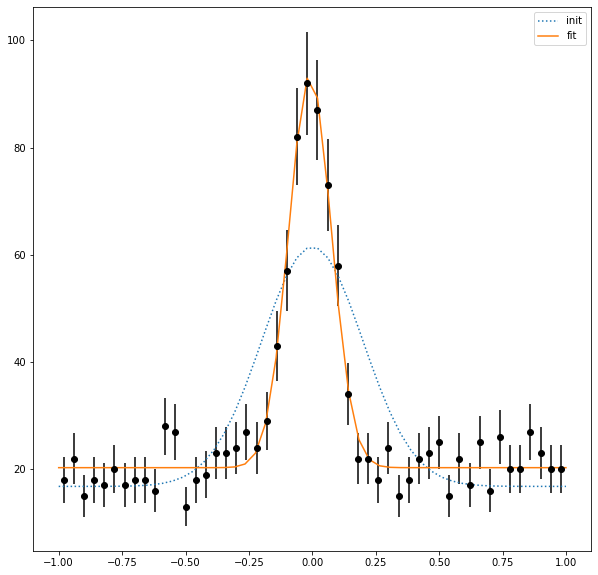

In [90]:
plt.errorbar(cx, n, n ** 0.5, fmt="ok")
xm = np.linspace(xe[0], xe[-1])
plt.plot(xm, model_pdf(xm, *[p.value for p in m.init_params]) * len(xdata) * dx[0],
         ls=":", label="init")
plt.plot(xm, model_pdf(xm, *m.values) * len(xdata) * dx[0], label="fit")
plt.legend();

### Extended unbinned fit

This is often used in the world of particle physics where we are trying to 

An important variant of the unbinned ML fit is described by Roger Barlow, *Nucl.Instrum.Meth.A 297 (1990) 496-506*. Use this if both the shape and the integral of the density are of interest. In practice, this is often the case, for example, if you want to estimate a cross-section or yield.

The model in this case has to return the integral of the density and the density itself (which must be vectorized). The parameters in this case are $n_{sig}$  (integral of the signal density), $n_{bkg}$ (integral of the uniform density), $\mu$  and $\sigma$ of the normal distribution. Again, the parameters need limits so that the problem is mathematically defined.

* $n_{sig} \gt 0$
* $n_{bkg} \gt 0$
* $-1 \lt \mu \lt 1$
* $\sigma \gt 0$

Compared to the previous case, we have one more parameter to fit. This is common to extended fits.

In [91]:
def model_density(x, nsig, nbkg, mu, sigma):
    return nsig + nbkg, (nsig * norm.pdf(x, mu, sigma) +
        nbkg * uniform.pdf(x, xrange[0], xrange[1] - xrange[0]))

c = cost.ExtendedUnbinnedNLL(xdata, model_density)

m = Minuit(c, nsig=300, nbkg=1500, mu=0, sigma=0.2)
m.limits["nsig", "nbkg", "sigma"] = (0, None)
m.limits["mu"] = (-1, 1)

m.migrad()

┌─────────────────────────────────────────────────────────────────────────┐
│                                Migrad                                   │
├──────────────────────────────────┬──────────────────────────────────────┤
│ FCN = -1.598e+04                 │              Nfcn = 110              │
│ EDM = 4.85e-05 (Goal: 0.0002)    │                                      │
├──────────────────────────────────┼──────────────────────────────────────┤
│          Valid Minimum           │   Below EDM threshold (goal x 10)    │
├──────────────────────────────────┼──────────────────────────────────────┤
│      No parameters at limit      │           Below call limit           │
├──────────────────────────────────┼──────────────────────────────────────┤
│             Hesse ok             │         Covariance accurate          │
└──────────────────────────────────┴──────────────────────────────────────┘
┌───┬───────┬───────────┬───────────┬────────────┬────────────┬─────────┬─────────┬───────┐
│   │ Name  │   Value   │ Hesse Err │ Minos Err- │ Minos Err+ │ Limit-  │ Limit+  │ Fixed │
├───┼───────┼───────────┼───────────┼────────────┼────────────┼─────────┼─────────┼───────┤
│ 0 │ nsig  │    385    │    26     │            │            │    0    │         │       │
│ 1 │ nbkg  │  1.01e3   │  0.04e3   │            │            │    0    │         │       │
│ 2 │ mu    │  -0.009   │   0.006   │            │            │   -1    │    1    │       │
│ 3 │ sigma │   0.084   │   0.006   │            │            │    0    │         │       │
└───┴───────┴───────────┴───────────┴────────────┴────────────┴─────────┴─────────┴───────┘
┌───────┬─────────────────────────────────────────────┐
│       │       nsig       nbkg         mu      sigma │
├───────┼─────────────────────────────────────────────┤
│  nsig │        689     -0.3e3   -5.10e-3  52.009e-3 │
│  nbkg │     -0.3e3   1.32e+03    5.10e-3 -51.996e-3 │
│    mu │   -5.10e-3    5.10e-3   3.79e-05  -0.002e-3 │
│ sigma │  52.009e-3 -51.996e-3  -0.002e-3   3.22e-05 │
└───────┴─────────────────────────────────────────────┘

The fitted values and the uncertainty estimates for $\mu$ and $\sigma$  are identical to the ordinary ML fit.

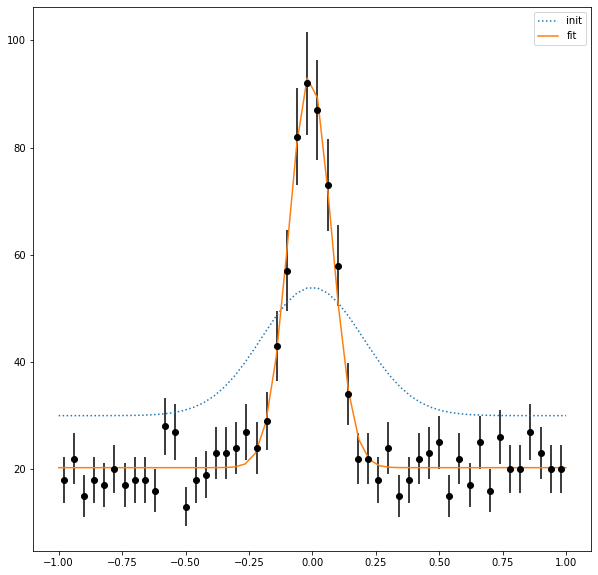

In [92]:
plt.errorbar(cx, n, n ** 0.5, fmt="ok")
xm = np.linspace(xe[0], xe[-1])
plt.plot(xm, model_density(xm, *[p.value for p in m.init_params])[1] * dx[0],
         ls=":", label="init")
plt.plot(xm, model_density(xm, *m.values)[1] * dx[0], label="fit")
plt.legend()

### Binned Fit
Binned fits are computationally more efficient and numerically more stable when samples are large. The caveat is that one has to choose an appropriate binning. The binning should be fine enough so that the essential information in the original is retained.

The sample investigate here is large enough and 50 bins are fine enough to retain all information. The maximum-likelihood method applied to binned data gives correct results even if bins no entries, so chosing a binning that is very fine is not an issue. It just increases the computational cost.

The cost functions for binned fits implemented here assume that the bin contents are independently Poisson distributed around an unknown expected value per bin. This is exactly correct for ordinary histograms.

For a binned maximum-likelihood fit, one sums the logarithm of Poisson probabilities for the observed counts as a function of the predicted counts in this case (times -1 to turn maximization into minimization). Instead of a pdf, you need to provide a cdf in this case (which must be vectorized). Note that you can approximate the cdf as “bin-width times pdf evaluated at center” if it is difficult to calculate, but this is an approxmiation. Using the cdf is exact.



In [93]:
def model_cdf(xe, z, mu, sigma):
    return (z * norm.cdf(xe, mu, sigma) +
            (1-z) * uniform.cdf(xe, xrange[0], xrange[1] - xrange[0]))

c = cost.BinnedNLL(n, xe, model_cdf)

m = Minuit(c, z=0.4, mu=0, sigma=0.2)

m.limits["z"] = (0, 1)
m.limits["mu"] = (-1, 1)
m.limits["sigma"] = (0, None)

m.migrad()

┌─────────────────────────────────────────────────────────────────────────┐
│                                Migrad                                   │
├──────────────────────────────────┬──────────────────────────────────────┤
│ FCN = 29.74 (χ²/ndof = 0.6)      │              Nfcn = 82               │
│ EDM = 1.88e-05 (Goal: 0.0002)    │                                      │
├──────────────────────────────────┼──────────────────────────────────────┤
│          Valid Minimum           │   Below EDM threshold (goal x 10)    │
├──────────────────────────────────┼──────────────────────────────────────┤
│      No parameters at limit      │           Below call limit           │
├──────────────────────────────────┼──────────────────────────────────────┤
│             Hesse ok             │         Covariance accurate          │
└──────────────────────────────────┴──────────────────────────────────────┘
┌───┬───────┬───────────┬───────────┬────────────┬────────────┬─────────┬─────────┬───────┐
│   │ Name  │   Value   │ Hesse Err │ Minos Err- │ Minos Err+ │ Limit-  │ Limit+  │ Fixed │
├───┼───────┼───────────┼───────────┼────────────┼────────────┼─────────┼─────────┼───────┤
│ 0 │ z     │   0.274   │   0.017   │            │            │    0    │    1    │       │
│ 1 │ mu    │  -0.008   │   0.006   │            │            │   -1    │    1    │       │
│ 2 │ sigma │   0.083   │   0.006   │            │            │    0    │         │       │
└───┴───────┴───────────┴───────────┴────────────┴────────────┴─────────┴─────────┴───────┘
┌───────┬───────────────────────────────┐
│       │         z        mu     sigma │
├───────┼───────────────────────────────┤
│     z │  0.000302        -0  0.041e-3 │
│    mu │        -0   3.9e-05 -0.003e-3 │
│ sigma │  0.041e-3 -0.003e-3  3.49e-05 │
└───────┴───────────────────────────────┘

The fitted values and the uncertainty estimates for μ and σ are not identical to the unbinned fit, but very close. For practical purposes, the results are equivalent. This shows that the binning is fine enough to retain the essential information in the original data.



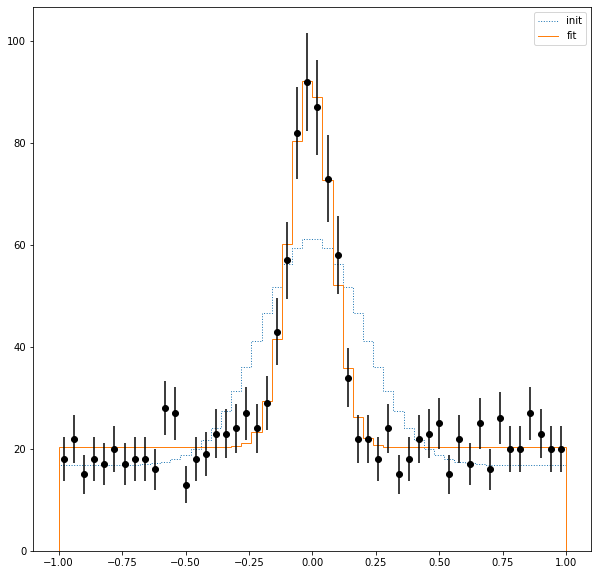

In [94]:
plt.errorbar(cx, n, n ** 0.5, fmt="ok")
plt.stairs(np.diff(model_cdf(xe, *[p.value for p in m.init_params])) * len(xdata), xe,
           ls=":", label="init")
plt.stairs(np.diff(model_cdf(xe, *m.values)) * len(xdata), xe, label="fit")
plt.legend();

### Extended binned maximum-likelihood fit
The binned extended maximum-likelihood fit is strictly the binned equivalent of the corresponding unbinned fit. One sums the logarithm of Poisson probabilities for the observed counts as a function of the predicted counts in this case (times -1 to turn maximization into minimization).

Instead of a density, you need to provide a cdf of the density in this case (which must be vectorized). There is no need to separately return the total integral like the unbinned case. The parameters are the same as in the unbinned extended fit.



In [95]:
def model_density_cdf(xe, nsig, nbkg, mu, sigma):
    return (nsig * norm.cdf(xe, mu, sigma) +
            nbkg * uniform.cdf(xe, xrange[0], xrange[1] - xrange[0]))

c = cost.ExtendedBinnedNLL(n, xe, model_density_cdf)

m = Minuit(c, nsig=300, nbkg=1500, mu=0, sigma=0.2)

m.limits["nsig", "nbkg", "sigma"] = (0, None)
m.limits["mu"] = (-1, 1)

m.migrad()

┌─────────────────────────────────────────────────────────────────────────┐
│                                Migrad                                   │
├──────────────────────────────────┬──────────────────────────────────────┤
│ FCN = 29.74 (χ²/ndof = 0.6)      │              Nfcn = 119              │
│ EDM = 6.67e-05 (Goal: 0.0002)    │                                      │
├──────────────────────────────────┼──────────────────────────────────────┤
│          Valid Minimum           │   Below EDM threshold (goal x 10)    │
├──────────────────────────────────┼──────────────────────────────────────┤
│      No parameters at limit      │           Below call limit           │
├──────────────────────────────────┼──────────────────────────────────────┤
│             Hesse ok             │         Covariance accurate          │
└──────────────────────────────────┴──────────────────────────────────────┘
┌───┬───────┬───────────┬───────────┬────────────┬────────────┬─────────┬─────────┬───────┐
│   │ Name  │   Value   │ Hesse Err │ Minos Err- │ Minos Err+ │ Limit-  │ Limit+  │ Fixed │
├───┼───────┼───────────┼───────────┼────────────┼────────────┼─────────┼─────────┼───────┤
│ 0 │ nsig  │    383    │    26     │            │            │    0    │         │       │
│ 1 │ nbkg  │  1.02e3   │  0.04e3   │            │            │    0    │         │       │
│ 2 │ mu    │  -0.008   │   0.006   │            │            │   -1    │    1    │       │
│ 3 │ sigma │   0.083   │   0.006   │            │            │    0    │         │       │
└───┴───────┴───────────┴───────────┴────────────┴────────────┴─────────┴─────────┴───────┘
┌───────┬─────────────────────────────────────────────┐
│       │       nsig       nbkg         mu      sigma │
├───────┼─────────────────────────────────────────────┤
│  nsig │        696     -0.3e3   -6.75e-3  56.672e-3 │
│  nbkg │     -0.3e3   1.33e+03    6.75e-3 -56.671e-3 │
│    mu │   -6.75e-3    6.75e-3   3.89e-05  -0.003e-3 │
│ sigma │  56.672e-3 -56.671e-3  -0.003e-3   3.48e-05 │
└───────┴─────────────────────────────────────────────┘

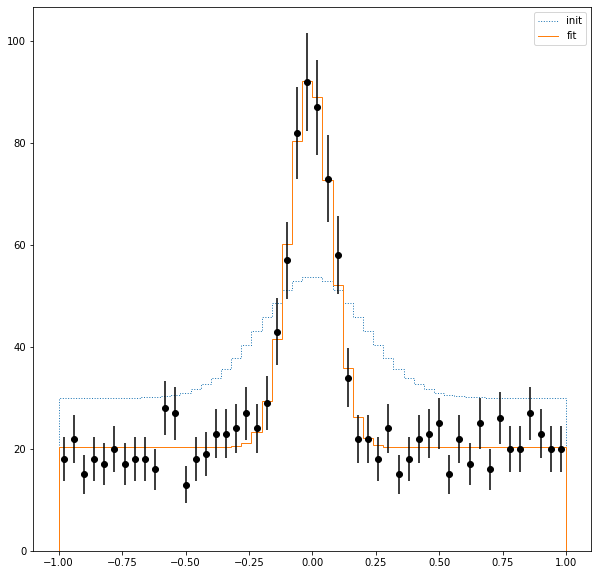

In [96]:
plt.errorbar(cx, n, n ** 0.5, fmt="ok")
plt.stairs(np.diff(model_density_cdf(xe, *[p.value for p in m.init_params])), xe,
           ls=":", label="init")
plt.stairs(np.diff(model_density_cdf(xe, *m.values)), xe, label="fit")
plt.legend();

### Temporary masking

In complicated binned fits with peak and background, it is sometimes useful to fit in several stages. One typically starts by masking the signal region, to fit only the background region.

This can be used to set up sensible values for a fit or to perform a blind analaysis.


The cost functions have a mask attribute to that end. We demonstrate the use of the mask with an extended binned fit.

In [97]:
def model_density_cdf(xe, nsig, nbkg, mu, sigma):
    return (nsig * norm.cdf(xe, mu, sigma) +
            nbkg * uniform.cdf(xe, xrange[0], xrange[1] - xrange[0]))

c = cost.ExtendedBinnedNLL(n, xe, model_density_cdf)

# we set the signal amplitude to zero and fix all signal parameters
m = Minuit(c, nsig=300, nbkg=1500, mu=0, sigma=0.2)

m.limits["nsig", "nbkg", "sigma"] = (0, None)
m.limits["mu"] = (-1, 1)
m.fixed["nsig", "mu", "sigma"] = True

# we temporarily mask out the signal
c.mask = (cx < -0.5) | (0.5 < cx)

m.migrad()

┌─────────────────────────────────────────────────────────────────────────┐
│                                Migrad                                   │
├──────────────────────────────────┬──────────────────────────────────────┤
│ FCN = 17.28 (χ²/ndof = 0.8)      │              Nfcn = 20               │
│ EDM = 2.39e-10 (Goal: 0.0002)    │                                      │
├──────────────────────────────────┼──────────────────────────────────────┤
│          Valid Minimum           │   Below EDM threshold (goal x 10)    │
├──────────────────────────────────┼──────────────────────────────────────┤
│      No parameters at limit      │           Below call limit           │
├──────────────────────────────────┼──────────────────────────────────────┤
│             Hesse ok             │         Covariance accurate          │
└──────────────────────────────────┴──────────────────────────────────────┘
┌───┬───────┬───────────┬───────────┬────────────┬────────────┬─────────┬─────────┬───────┐
│   │ Name  │   Value   │ Hesse Err │ Minos Err- │ Minos Err+ │ Limit-  │ Limit+  │ Fixed │
├───┼───────┼───────────┼───────────┼────────────┼────────────┼─────────┼─────────┼───────┤
│ 0 │ nsig  │    300    │     3     │            │            │    0    │         │  yes  │
│ 1 │ nbkg  │  1.00e3   │  0.05e3   │            │            │    0    │         │       │
│ 2 │ mu    │    0.0    │    0.1    │            │            │   -1    │    1    │  yes  │
│ 3 │ sigma │   0.200   │   0.002   │            │            │    0    │         │  yes  │
└───┴───────┴───────────┴───────────┴────────────┴────────────┴─────────┴─────────┴───────┘
┌───────┬─────────────────────────────────┐
│       │    nsig    nbkg      mu   sigma │
├───────┼─────────────────────────────────┤
│  nsig │       0       0       0       0 │
│  nbkg │       0 2.1e+03       0       0 │
│    mu │       0       0       0       0 │
│ sigma │       0       0       0       0 │
└───────┴─────────────────────────────────┘

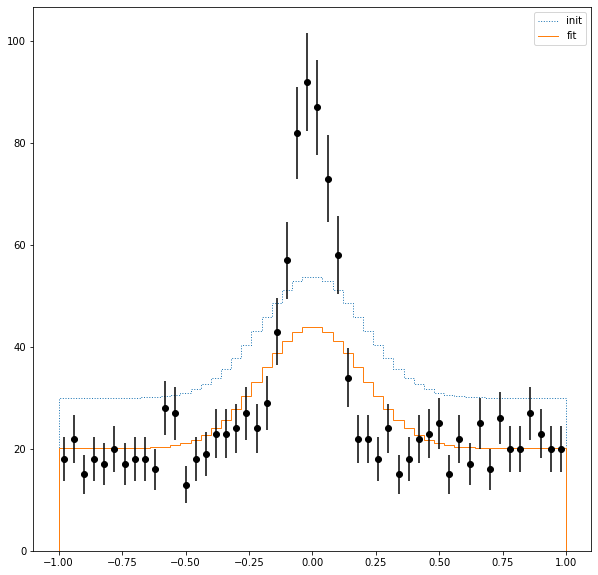

In [98]:
plt.errorbar(cx, n, n ** 0.5, fmt="ok")
plt.stairs(np.diff(model_density_cdf(xe, *[p.value for p in m.init_params])), xe,
           ls=":", label="init")
plt.stairs(np.diff(model_density_cdf(xe, *m.values)), xe, label="fit")
plt.legend();

Now we fix the background and fit only the signal parameters.

In [99]:
c.mask = None # remove mask
m.fixed = False # release all parameters
m.fixed["nbkg"] = True # fix background amplitude

m.migrad()

┌─────────────────────────────────────────────────────────────────────────┐
│                                Migrad                                   │
├──────────────────────────────────┬──────────────────────────────────────┤
│ FCN = 29.86 (χ²/ndof = 0.6)      │              Nfcn = 91               │
│ EDM = 8.78e-05 (Goal: 0.0002)    │                                      │
├──────────────────────────────────┼──────────────────────────────────────┤
│          Valid Minimum           │   Below EDM threshold (goal x 10)    │
├──────────────────────────────────┼──────────────────────────────────────┤
│      No parameters at limit      │           Below call limit           │
├──────────────────────────────────┼──────────────────────────────────────┤
│             Hesse ok             │         Covariance accurate          │
└──────────────────────────────────┴──────────────────────────────────────┘
┌───┬───────┬───────────┬───────────┬────────────┬────────────┬─────────┬─────────┬───────┐
│   │ Name  │   Value   │ Hesse Err │ Minos Err- │ Minos Err+ │ Limit-  │ Limit+  │ Fixed │
├───┼───────┼───────────┼───────────┼────────────┼────────────┼─────────┼─────────┼───────┤
│ 0 │ nsig  │    386    │    25     │            │            │    0    │         │       │
│ 1 │ nbkg  │  1.00e3   │  0.05e3   │            │            │    0    │         │  yes  │
│ 2 │ mu    │  -0.008   │   0.006   │            │            │   -1    │    1    │       │
│ 3 │ sigma │   0.084   │   0.006   │            │            │    0    │         │       │
└───┴───────┴───────────┴───────────┴────────────┴────────────┴─────────┴─────────┴───────┘
┌───────┬─────────────────────────────────────────┐
│       │      nsig      nbkg        mu     sigma │
├───────┼─────────────────────────────────────────┤
│  nsig │       625         0  -5.29e-3 43.938e-3 │
│  nbkg │         0         0         0         0 │
│    mu │  -5.29e-3         0   3.9e-05 -0.003e-3 │
│ sigma │ 43.938e-3         0 -0.003e-3  3.29e-05 │
└───────┴─────────────────────────────────────────┘

Finally, we release all parameters and fit again to get the correct uncertainty estimates.



In [100]:
m.fixed = None
m.migrad()

┌─────────────────────────────────────────────────────────────────────────┐
│                                Migrad                                   │
├──────────────────────────────────┬──────────────────────────────────────┤
│ FCN = 29.74 (χ²/ndof = 0.6)      │              Nfcn = 158              │
│ EDM = 5.84e-06 (Goal: 0.0002)    │                                      │
├──────────────────────────────────┼──────────────────────────────────────┤
│          Valid Minimum           │   Below EDM threshold (goal x 10)    │
├──────────────────────────────────┼──────────────────────────────────────┤
│      No parameters at limit      │           Below call limit           │
├──────────────────────────────────┼──────────────────────────────────────┤
│             Hesse ok             │         Covariance accurate          │
└──────────────────────────────────┴──────────────────────────────────────┘
┌───┬───────┬───────────┬───────────┬────────────┬────────────┬─────────┬─────────┬───────┐
│   │ Name  │   Value   │ Hesse Err │ Minos Err- │ Minos Err+ │ Limit-  │ Limit+  │ Fixed │
├───┼───────┼───────────┼───────────┼────────────┼────────────┼─────────┼─────────┼───────┤
│ 0 │ nsig  │    383    │    26     │            │            │    0    │         │       │
│ 1 │ nbkg  │  1.02e3   │  0.04e3   │            │            │    0    │         │       │
│ 2 │ mu    │  -0.008   │   0.006   │            │            │   -1    │    1    │       │
│ 3 │ sigma │   0.083   │   0.006   │            │            │    0    │         │       │
└───┴───────┴───────────┴───────────┴────────────┴────────────┴─────────┴─────────┴───────┘
┌───────┬─────────────────────────────────────────────┐
│       │       nsig       nbkg         mu      sigma │
├───────┼─────────────────────────────────────────────┤
│  nsig │        696     -0.3e3   -6.76e-3  56.718e-3 │
│  nbkg │     -0.3e3   1.33e+03    6.76e-3 -56.713e-3 │
│    mu │   -6.76e-3    6.76e-3   3.89e-05  -0.003e-3 │
│ sigma │  56.718e-3 -56.713e-3  -0.003e-3   3.49e-05 │
└───────┴─────────────────────────────────────────────┘

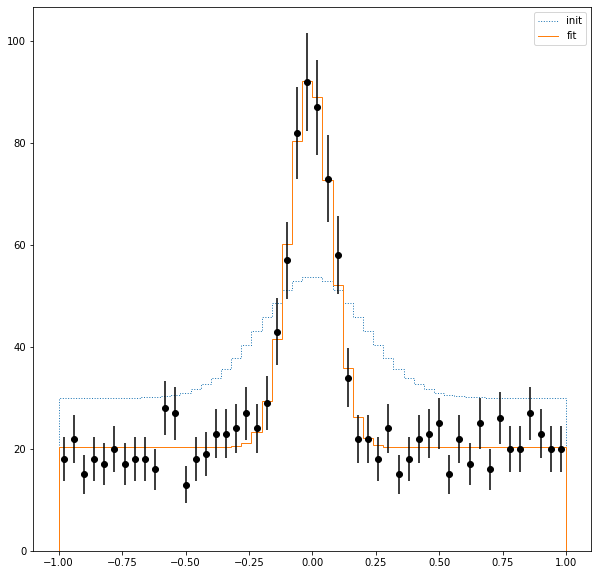

In [101]:
plt.errorbar(cx, n, n ** 0.5, fmt="ok")
plt.stairs(np.diff(model_density_cdf(xe, *[p.value for p in m.init_params])), xe,
           ls=":", label="init")
plt.stairs(np.diff(model_density_cdf(xe, *m.values)), xe, label="fit")
plt.legend();

We get the same result, of course. Since this was an easy problem, we did not need these extra steps, but doing this is usually helpful to fit lots of histograms without adjusting each fit manually.

### Weighted histograms
The cost functions for binned data also support weighted histograms. Just pass an array with the shape (n, 2) instead of (n,) as the first argument, where the first number of each pair is the sum of weights and the second is the sum of weights squared (an estimate of the variance of that bin value).

### Least-squares fits

A cost function for a general weighted least-squares fit (aka chi-square fit) is also included. In statistics this is called non-linear regression.

In this case you need to provide a model that predicts the y-values as a function of the x-values and the parameters. The fit needs estimates of the y-errors. If those are wrong, the fit may be biased. If your data has errors on the x-values as well, checkout the tutorial about automatic differentiation, which includes an application of that to such fits.

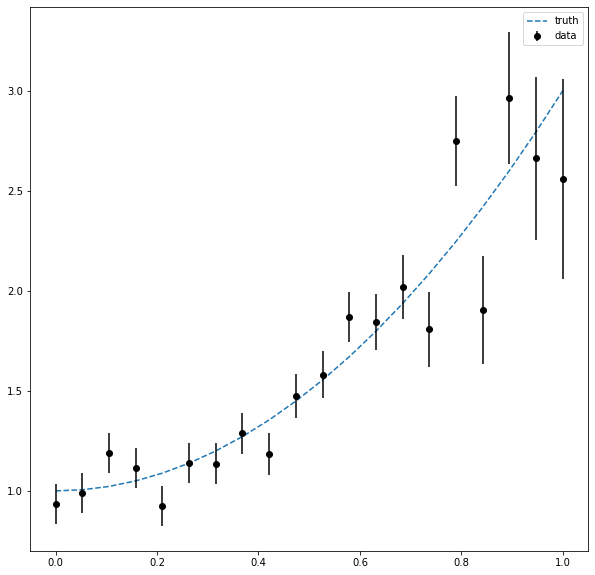

In [102]:
def model(x, a, b):
    return a + b * x ** 2

rng = np.random.default_rng(4)

x = np.linspace(0, 1, 20)
yt = model(x, 1, 2)
ye = 0.4 * x**5 + 0.1
y = rng.normal(yt, ye)

plt.plot(x, yt, ls="--", label="truth")
plt.errorbar(x, y, ye, fmt="ok", label="data")
plt.legend();

In [103]:
c = cost.LeastSquares(x, y, ye, model)

m = Minuit(c, a=0, b=0)
m.migrad()

┌─────────────────────────────────────────────────────────────────────────┐
│                                Migrad                                   │
├──────────────────────────────────┬──────────────────────────────────────┤
│ FCN = 25.29 (χ²/ndof = 1.4)      │              Nfcn = 29               │
│ EDM = 2.27e-22 (Goal: 0.0002)    │                                      │
├──────────────────────────────────┼──────────────────────────────────────┤
│          Valid Minimum           │   Below EDM threshold (goal x 10)    │
├──────────────────────────────────┼──────────────────────────────────────┤
│      No parameters at limit      │           Below call limit           │
├──────────────────────────────────┼──────────────────────────────────────┤
│             Hesse ok             │         Covariance accurate          │
└──────────────────────────────────┴──────────────────────────────────────┘
┌───┬──────┬───────────┬───────────┬────────────┬────────────┬─────────┬─────────┬───────┐
│   │ Name │   Value   │ Hesse Err │ Minos Err- │ Minos Err+ │ Limit-  │ Limit+  │ Fixed │
├───┼──────┼───────────┼───────────┼────────────┼────────────┼─────────┼─────────┼───────┤
│ 0 │ a    │   0.99    │   0.04    │            │            │         │         │       │
│ 1 │ b    │   2.04    │   0.15    │            │            │         │         │       │
└───┴──────┴───────────┴───────────┴────────────┴────────────┴─────────┴─────────┴───────┘
┌───┬─────────────────┐
│   │       a       b │
├───┼─────────────────┤
│ a │ 0.00139 -0.0037 │
│ b │ -0.0037  0.0226 │
└───┴─────────────────┘

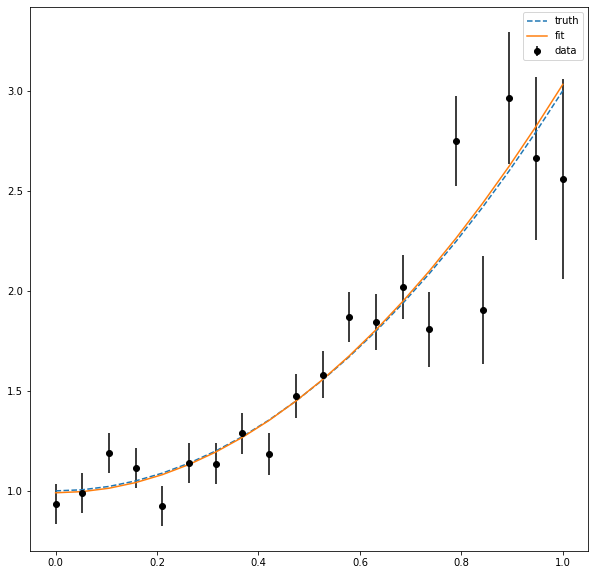

In [104]:
plt.errorbar(x, y, ye, fmt="ok", label="data")
plt.plot(x, model(x, 1, 2), ls="--", label="truth")
plt.plot(x, model(x, *m.values), label="fit")
plt.legend();

### Robust least-squares
The builtin least-squares function also supports robust fitting with alternative loss functions. See the documentation of iminuit.cost.LeastSquares for details. Users can pass their own loss functions. Builtin loss functions are:

* linear (default): gives ordinary weighted least-squares

* soft_l1: quadratic ordinary loss for small deviations $(\ll 1\sigma)$, linear loss for large deviations $(\gg 1\sigma)$, and smooth interpolation in between

Let’s create one outlier and see what happens with ordinary loss.



In [105]:
def model(x, a, b):
    return a + b * x ** 2

rng = np.random.default_rng(4)

x = np.linspace(0, 1, 20)
yt = model(x, 1, 2)
ye = 0.4 * x**5 + 0.1
y = rng.normal(yt, ye)
y[3] = 3 # generate an outlier

c = cost.LeastSquares(x, y, ye, model)

m = Minuit(c, a=0, b=0)
m.migrad()

┌─────────────────────────────────────────────────────────────────────────┐
│                                Migrad                                   │
├──────────────────────────────────┬──────────────────────────────────────┤
│ FCN = 364.9 (χ²/ndof = 20.3)     │              Nfcn = 29               │
│ EDM = 9.85e-22 (Goal: 0.0002)    │                                      │
├──────────────────────────────────┼──────────────────────────────────────┤
│          Valid Minimum           │   Below EDM threshold (goal x 10)    │
├──────────────────────────────────┼──────────────────────────────────────┤
│      No parameters at limit      │           Below call limit           │
├──────────────────────────────────┼──────────────────────────────────────┤
│             Hesse ok             │         Covariance accurate          │
└──────────────────────────────────┴──────────────────────────────────────┘
┌───┬──────┬───────────┬───────────┬────────────┬────────────┬─────────┬─────────┬───────┐
│   │ Name │   Value   │ Hesse Err │ Minos Err- │ Minos Err+ │ Limit-  │ Limit+  │ Fixed │
├───┼──────┼───────────┼───────────┼────────────┼────────────┼─────────┼─────────┼───────┤
│ 0 │ a    │   1.23    │   0.04    │            │            │         │         │       │
│ 1 │ b    │   1.45    │   0.15    │            │            │         │         │       │
└───┴──────┴───────────┴───────────┴────────────┴────────────┴─────────┴─────────┴───────┘
┌───┬─────────────────┐
│   │       a       b │
├───┼─────────────────┤
│ a │ 0.00139 -0.0037 │
│ b │ -0.0037  0.0226 │
└───┴─────────────────┘

Now see what this looks like

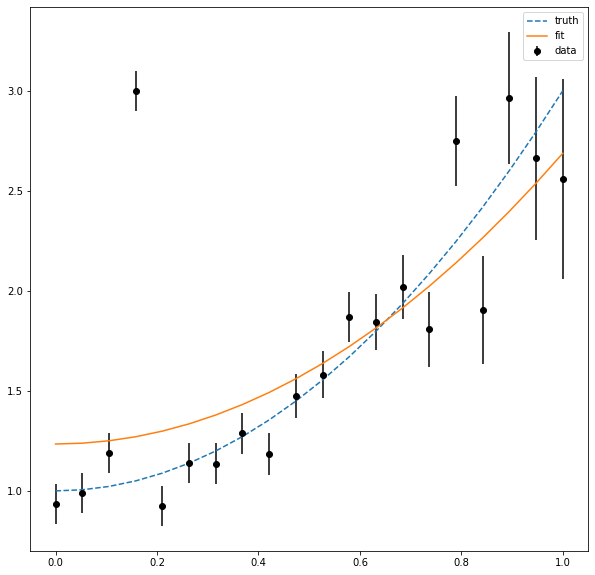

In [106]:
plt.errorbar(x, y, ye, fmt="ok", label="data")
plt.plot(x, model(x, 1, 2), ls="--", label="truth")
plt.plot(x, model(x, *m.values), label="fit")
plt.legend();

The result is distorted by the outlier. We can repair this with the soft_l1 loss.

In [107]:
c.loss = "soft_l1"
m.migrad()

┌─────────────────────────────────────────────────────────────────────────┐
│                                Migrad                                   │
├──────────────────────────────────┬──────────────────────────────────────┤
│ FCN = 54.09 (χ²/ndof = 3.0)      │              Nfcn = 69               │
│ EDM = 4.31e-06 (Goal: 0.0002)    │                                      │
├──────────────────────────────────┼──────────────────────────────────────┤
│          Valid Minimum           │   Below EDM threshold (goal x 10)    │
├──────────────────────────────────┼──────────────────────────────────────┤
│      No parameters at limit      │           Below call limit           │
├──────────────────────────────────┼──────────────────────────────────────┤
│             Hesse ok             │         Covariance accurate          │
└──────────────────────────────────┴──────────────────────────────────────┘
┌───┬──────┬───────────┬───────────┬────────────┬────────────┬─────────┬─────────┬───────┐
│   │ Name │   Value   │ Hesse Err │ Minos Err- │ Minos Err+ │ Limit-  │ Limit+  │ Fixed │
├───┼──────┼───────────┼───────────┼────────────┼────────────┼─────────┼─────────┼───────┤
│ 0 │ a    │   1.00    │   0.05    │            │            │         │         │       │
│ 1 │ b    │   2.04    │   0.23    │            │            │         │         │       │
└───┴──────┴───────────┴───────────┴────────────┴────────────┴─────────┴─────────┴───────┘
┌───┬─────────────────┐
│   │       a       b │
├───┼─────────────────┤
│ a │ 0.00285 -0.0086 │
│ b │ -0.0086  0.0524 │
└───┴─────────────────┘

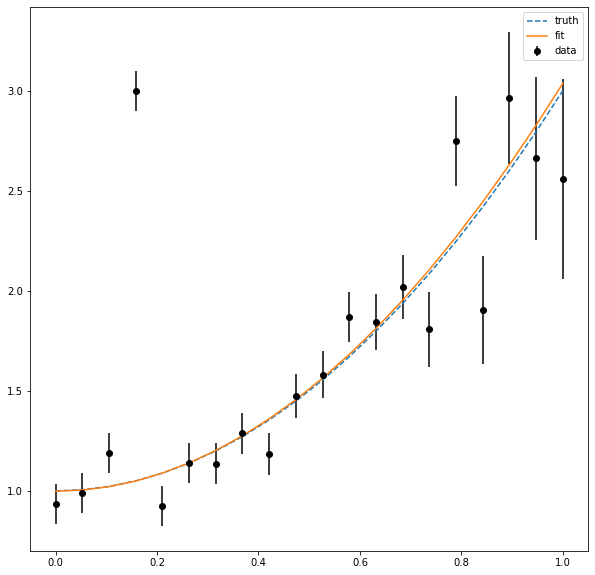

In [108]:
plt.errorbar(x, y, ye, fmt="ok", label="data")
plt.plot(x, model(x, 1, 2), ls="--", label="truth")
plt.plot(x, model(x, *m.values), label="fit")
plt.legend();

The result is now practically identical as in the previous case without an outlier.

Robust fitting is a very powerful if the data are contaminated with small amounts of outliers. It comes with a price, however, the uncertainties are in general larger. Compare the estimated uncertainty of the parameter b, which was 0.15 and now is 0.23.

We can actually do better by manually removing the point (using the mask attribute) and switching back to ordinary loss. **You should always be careful removing any data without a good reason.**



In [109]:
c.mask = c.x != c.x[3]
c.loss = "linear"
m.migrad()

┌─────────────────────────────────────────────────────────────────────────┐
│                                Migrad                                   │
├──────────────────────────────────┬──────────────────────────────────────┤
│ FCN = 24.67 (χ²/ndof = 1.5)      │              Nfcn = 100              │
│ EDM = 1.36e-23 (Goal: 0.0002)    │                                      │
├──────────────────────────────────┼──────────────────────────────────────┤
│          Valid Minimum           │   Below EDM threshold (goal x 10)    │
├──────────────────────────────────┼──────────────────────────────────────┤
│      No parameters at limit      │           Below call limit           │
├──────────────────────────────────┼──────────────────────────────────────┤
│             Hesse ok             │         Covariance accurate          │
└──────────────────────────────────┴──────────────────────────────────────┘
┌───┬──────┬───────────┬───────────┬────────────┬────────────┬─────────┬─────────┬───────┐
│   │ Name │   Value   │ Hesse Err │ Minos Err- │ Minos Err+ │ Limit-  │ Limit+  │ Fixed │
├───┼──────┼───────────┼───────────┼────────────┼────────────┼─────────┼─────────┼───────┤
│ 0 │ a    │   0.98    │   0.04    │            │            │         │         │       │
│ 1 │ b    │   2.07    │   0.15    │            │            │         │         │       │
└───┴──────┴───────────┴───────────┴────────────┴────────────┴─────────┴─────────┴───────┘
┌───┬─────────────────┐
│   │       a       b │
├───┼─────────────────┤
│ a │ 0.00158 -0.0041 │
│ b │ -0.0041  0.0238 │
└───┴─────────────────┘

Now the uncertainty on $b$ is back to 0.15.

## Exercise ##

This is a slightly longer exercise that is very close to real data analaysis. The data in data1 contains a signle on a falling background. Find where this signal is, characterise it (finds its location,width and how many events it contains). Finally display it clearly - for example you may want to subtract the background and you may want to think about how you display the uncertainties in your characterisation. These data are in pickle format and so you will have to learn how to use pickle.

# The iminuit doumentation also has excellent tutorials on:
# * Fits withshared parameters
# * Fit PDF with conditional variables

# That we recommend that you do when you have time.
 
# Infact all the [tutorial](https://iminuit.readthedocs.io/en/stable/tutorials.html) are excellent